In [509]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kruskal, pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold, RFECV
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)

warnings.filterwarnings('ignore')



In [510]:
#loading the dataset

df_trustpilot = pd.read_csv('data/data_trustpilot_3.csv', engine='python')
train_df = pd.read_csv('data/train_trustpilot_3.csv', engine='python')
test_df = pd.read_csv('data/test_trustpilot_3.csv', engine='python')

# Load TF-IDF matrices
X_train_tfidf = np.load('data/X_train_tfidf.npy')
X_test_tfidf = np.load('data/X_test_tfidf.npy')
tfidf_features = np.load('data/tfidf_features.npy', allow_pickle=True)

# Load BoW matrices
X_train_bow = np.load('data/X_train_bow.npy')
X_test_bow = np.load('data/X_test_bow.npy')
bow_features = np.load('data/bow_features.npy', allow_pickle=True)


print("Dataset shapes:")
print(f"Full dataset: {df_trustpilot.shape}")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

print("Text feature matrices shapes:")
print(f"TF-IDF training: {X_train_tfidf.shape}")
print(f"TF-IDF testing: {X_test_tfidf.shape}")
print(f"BoW training: {X_train_bow.shape}")
print(f"BoW testing: {X_test_bow.shape}")

display(train_df.head())



Dataset shapes:
Full dataset: (64228, 34)
Training set: (51382, 34)
Test set: (12846, 34)
Text feature matrices shapes:
TF-IDF training: (51382, 5000)
TF-IDF testing: (12846, 5000)
BoW training: (51382, 5000)
BoW testing: (12846, 5000)


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,US,Paul D.,1,Verified,one-time,0,Flashbay,fast and efficient web site that allowed a simple interface to to upload my logo and choose my product. The whole process was quick and the product was of great quality.,fast efficient web site allowed simple interface upload logo choose product whole process quick product great quality,117,17,0.307,4.0,0.784,5,fast and efficient web site that…,fast efficient web site,23.0,4.0,"Hello Paul,That is Flashbay for you!Glad that you have found the ordering process easy, and are pleased with the final product.We appreciate your business, and look forward to working with you next time!-Flashbay Management",hello paulthat flashbay youglad found ordering process easy pleased final productwe appreciate business look forward working next timeflashbay management,1,2021-08-11,2021-08-11 17:03:19,2021-08-11,8,10,Business Hours,2,Business Day,0,quick_review,1
1,4,US,Tim Deutschle,1,Verified,one-time,0,Quicken,"I have used Quicken for many years, more than 30 years for sure. I find it difficult sometimes when adding accounts. Also, when entering CD’s and establishing a maturity schedule.",used quicken many years 30 years sure find difficult sometimes adding accounts also entering cds establishing maturity schedule,127,18,0.167,3.0,-0.052,3,I have used Quicken for many years,used quicken many years,23.0,4.0,0,0,0,2024-04-24,2024-05-01 16:23:54,2024-05-01,5,9,Business Hours,2,Business Day,0,late_review,0
2,1,GB,Matthew Hanshaw,2,Not Verified,repeat,1,Asda,A pile of s**t !!!!!!!!!!! Also you don’t even warrant a star had to select it to leave this review.,pile st also dont even warrant star select leave review,55,10,0.000,3.0,-0.052,3,A pile of s**t,pile st,7.0,2.0,0,0,0,2023-08-07,2023-08-08 21:16:55,2023-08-08,8,20,Evening,1,Business Day,0,late_review,0
3,2,US,Michael,1,Invited,one-time,0,Quicken,Not a super useful or intuitive tool. Better free options exist.,super useful intuitive tool better free options exist,53,8,0.383,4.0,0.919,5,Not a super useful or intuitive tool,super useful intuitive tool,27.0,4.0,0,0,0,2023-09-05,2023-09-05 18:27:02,2023-09-05,9,11,Business Hours,1,Business Day,0,quick_review,1
4,2,US,Alan,2,Invited,repeat,1,Quicken,not intuitive....poor guidelines and instructions on usage,intuitivepoor guidelines instructions usage,43,4,0.000,3.0,0.000,3,not intuitive....poor guidelines and…,intuitivepoor guidelines,24.0,2.0,0,0,0,2021-12-08,2021-12-08 02:43:54,2021-12-07,12,19,Evening,1,Business Day,0,quick_review,1


In [511]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
print(df_trustpilot.columns)
display(df_trustpilot.info())

train_df['local_date_posted'] = pd.to_datetime(train_df['local_date_posted'])
train_df['date_of_experience'] = pd.to_datetime(train_df['date_of_experience'])
train_df['date_posted'] = pd.to_datetime(train_df['date_posted'])
print(train_df.columns)
display(train_df.info())

test_df['local_date_posted'] = pd.to_datetime(test_df['local_date_posted'])
test_df['date_of_experience'] = pd.to_datetime(test_df['date_of_experience'])
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])
print(test_df.columns)
display(test_df.info())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64228 entries, 0 to 64227
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64228 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51382 entries, 0 to 51381
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            51382 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12846 entries, 0 to 12845
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            12846 non-null  in

None

STAGE 1 - HEATMAP & MULTICOLLINEARITY

In [512]:
# Split variables by type
binary_variables = ['repeat_reviewer', 'repeat_reviewer_encoded', 'answered_encoded', 'day_type', 'review_time', 'review_time_encoded']

categorical_text = ['location', 'username', 'verification', 'company', 'text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'time_of_day']

categorical_ordinal = ['rating', 'Sentiment_Blob_cat',  'Sentiment_VADER_cat']

true_numeric = ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'days_between_experience_and_post']

time_based_numeric = ['month_local', 'local_hour',  'day_of_week_posted']

datetime_columns = ['date_of_experience', 'date_posted', 'local_date_posted']

# Create DataFrame with numeric and ordinal features for correlation analysis
numeric_for_correlation = train_df[true_numeric + categorical_ordinal + time_based_numeric].copy()

# Create DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(X_train_tfidf, columns=[f'tfidf_{i}' for i in range(X_train_tfidf.shape[1])])
top_n_tfidf = 5
top_tfidf_cols = tfidf_df.var().nlargest(top_n_tfidf).index

# Create DataFrame with BoW features
bow_df = pd.DataFrame(X_train_bow, columns=[f'bow_{i}' for i in range(X_train_bow.shape[1])])
top_n_bow = 5
top_bow_cols = bow_df.var().nlargest(top_n_bow).index



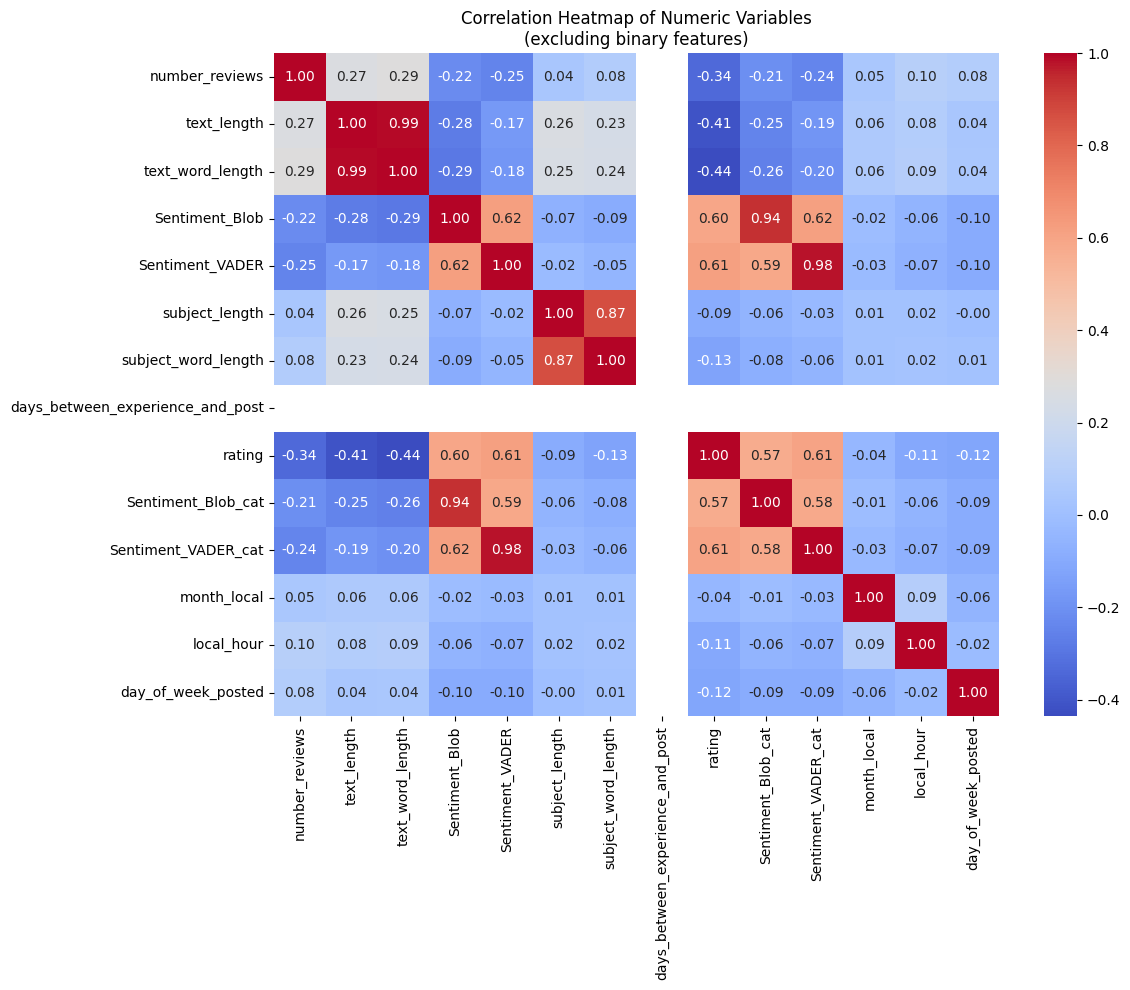

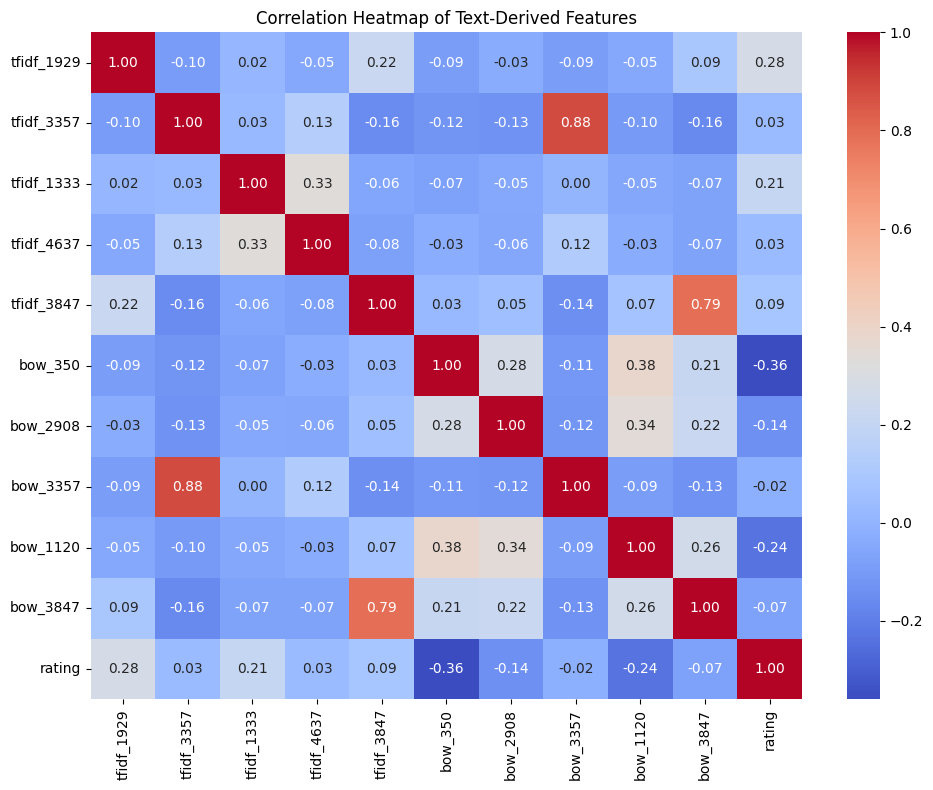

Highly correlated pairs (>0.7) with analysis:

Original Numeric Variables:

text_word_length & text_length: 0.994
Correlation with rating: text_word_length: 0.436, text_length: 0.413
Recommendation: Keep text_word_length (stronger correlation with target)

subject_word_length & subject_length: 0.870
Correlation with rating: subject_word_length: 0.131, subject_length: 0.090
Recommendation: Keep subject_word_length (stronger correlation with target)

Sentiment_Blob_cat & Sentiment_Blob: 0.936
Correlation with rating: Sentiment_Blob_cat: 0.568, Sentiment_Blob: 0.596
Recommendation: Keep Sentiment_Blob (stronger correlation with target)

Sentiment_VADER_cat & Sentiment_VADER: 0.982
Correlation with rating: Sentiment_VADER_cat: 0.605, Sentiment_VADER: 0.613
Recommendation: Keep Sentiment_VADER (stronger correlation with target)

Text-Derived Features:

bow_3357 & tfidf_3357: 0.880
Correlation with rating: bow_3357: 0.016, tfidf_3357: 0.028
Recommendation: Keep tfidf_3357 (stronger correlati

In [513]:
# Correlation heatmaps
# 1. True numeric and ordinal variables
original_corr = numeric_for_correlation.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables\n(excluding binary features)')
plt.tight_layout()
plt.show()

# 2. Text-derived features
text_features_with_rating = pd.concat([tfidf_df[top_tfidf_cols], bow_df[top_bow_cols], train_df['rating']], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(text_features_with_rating, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Text-Derived Features')
plt.tight_layout()
plt.show()

# Analyze correlations and print results
print("Highly correlated pairs (>0.7) with analysis:")
print("\nOriginal Numeric Variables:")
for i in range(len(original_corr.columns)):
    for j in range(i):
        if abs(original_corr.iloc[i, j]) > 0.7:
            var1 = original_corr.columns[i]
            var2 = original_corr.columns[j]
            correlation = original_corr.iloc[i, j]
            corr_with_target1 = abs(original_corr.loc[var1, 'rating'])
            corr_with_target2 = abs(original_corr.loc[var2, 'rating'])
            print(f"\n{var1} & {var2}: {correlation:.3f}")
            print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                  f"{var2}: {corr_with_target2:.3f}")
            print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                  f"(stronger correlation with target)")

print("\nText-Derived Features:")
for i in range(len(text_features_with_rating.columns)):
    for j in range(i):
        if abs(text_features_with_rating.iloc[i, j]) > 0.7:
            var1 = text_features_with_rating.columns[i]
            var2 = text_features_with_rating.columns[j]
            if var1 != 'rating' and var2 != 'rating':
                correlation = text_features_with_rating.iloc[i, j]
                corr_with_target1 = abs(text_features_with_rating.loc[var1, 'rating'])
                corr_with_target2 = abs(text_features_with_rating.loc[var2, 'rating'])
                print(f"\n{var1} & {var2}: {correlation:.3f}")
                print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                      f"{var2}: {corr_with_target2:.3f}")
                print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                      f"(stronger correlation with target)")

print("\nNote: Binary variables were excluded from correlation analysis as they require "
      "different statistical approaches (e.g., point-biserial correlation).")

In [514]:
# Point-biserial correlation with binary features and'rating'
for binary_var in ['repeat_reviewer_encoded', 'answered_encoded', 'review_time_encoded']:
    corr, p_value = pointbiserialr(train_df[binary_var], train_df['rating'])
    print(f"{binary_var}: Point-biserial correlation with 'rating' = {corr:.3f} (p-value = {p_value:.3e})")


repeat_reviewer_encoded: Point-biserial correlation with 'rating' = -0.250 (p-value = 0.000e+00)
answered_encoded: Point-biserial correlation with 'rating' = 0.395 (p-value = 0.000e+00)
review_time_encoded: Point-biserial correlation with 'rating' = 0.126 (p-value = 1.023e-179)


STAGE 2 - VARIANCE THRESHOLD

In [515]:
#Variance Threshold
def analyze_variance_threshold(threshold=0.01):
    print("\nThresholds being used:")
    print(f"General threshold: {threshold}")
    print(f"Binary features threshold: 0.05")

    results = []
    
    # Helper function to safely get variance
    def get_variance(feature_data):
        try:
            return float(feature_data.var())
        except:
            return 0.0
    
    # Process numeric features
    for feature in true_numeric + time_based_numeric:
        if feature in train_df.columns:
            var = get_variance(train_df[feature])
            print(f"Numeric feature '{feature}' variance: {var:.6f}")  
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Numeric',
                'low_variance': var < threshold,
                'threshold_used': threshold
            })
    
    # Process binary features
    binary_threshold = 0.01
    for feature in [col for col in binary_variables if col.endswith('_encoded')]:
        if feature in train_df.columns:
            var = get_variance(train_df[feature])
            print(f"Binary feature '{feature}' variance: {var:.6f}")  
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Binary',
                'low_variance': var < binary_threshold,
                'threshold_used': binary_threshold
            })
    
    # Process sentiment features
    sentiment_features = ['Sentiment_Blob', 'Sentiment_VADER', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat']
    for feature in sentiment_features:
        if feature in train_df.columns:
            var = get_variance(train_df[feature])
            print(f"Sentiment feature '{feature}' variance: {var:.6f}") 
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Sentiment',
                'low_variance': var < threshold,
                'threshold_used': threshold
            })
    
    # Process text metrics
    text_metrics = ['text_length', 'text_word_length', 'subject_length', 'subject_word_length']
    for feature in text_metrics:
        if feature in train_df.columns:
            var = get_variance(train_df[feature])
            print(f"Text metric feature '{feature}' variance: {var:.6f}")  
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Text-Metric',
                'low_variance': var < threshold,
                'threshold_used': threshold
            })
    
    # Process TF-IDF features
    if 'X_train_tfidf' in globals() and isinstance(X_train_tfidf, np.ndarray):
        for idx, feature in enumerate(top_tfidf_cols):
            var = float(np.var(X_train_tfidf[:, idx]))
            print(f"TF-IDF feature '{feature}' variance: {var:.6f}")  
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'TF-IDF',
                'low_variance': var < threshold,
                'threshold_used': threshold
            })
    
    # Process BoW features
    if 'X_train_bow' in globals() and isinstance(X_train_bow, np.ndarray):
        for idx, feature in enumerate(top_bow_cols):
            var = float(np.var(X_train_bow[:, idx]))
            print(f"BoW feature '{feature}' variance: {var:.6f}")  
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'BoW',
                'low_variance': var < threshold,
                'threshold_used': threshold
            })
    
    # Create summary DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('variance', ascending=False)
    
    # Display results
    print("\nVariance Threshold Analysis")
    print("=" * 50)
    print(f"\nFeatures analyzed: {len(results_df)}")
    print(f"Low variance features: {results_df['low_variance'].sum()}")
    
    # Group by feature type and show thresholds used
    print("\nAnalysis by Feature Type:")
    type_summary = results_df.groupby('type').agg({
        'feature': 'count',
        'low_variance': 'sum',
        'threshold_used': 'first'
    }).rename(columns={
        'feature': 'total_features',
        'low_variance': 'low_variance_features',
        'threshold_used': 'threshold'
    })
    display(type_summary)
    
    # Display recommendations with thresholds
    keep_df = results_df[~results_df['low_variance']].sort_values('variance', ascending=False)
    drop_df = results_df[results_df['low_variance']].sort_values('variance', ascending=False)
    
    print("\nRecommendations:")
    print("\nFeatures to keep:")
    display(keep_df[['feature', 'type', 'variance', 'threshold_used']])
    
    if len(drop_df) > 0:
        print(f"\nFeatures below threshold (to be dropped):")
        display(drop_df[['feature', 'type', 'variance', 'threshold_used']])
    
    return results_df


variance_results = analyze_variance_threshold(threshold=0.01)

features_to_keep = variance_results[~variance_results['low_variance']]['feature'].tolist()
features_to_drop = variance_results[variance_results['low_variance']]['feature'].tolist()



Thresholds being used:
General threshold: 0.01
Binary features threshold: 0.05
Numeric feature 'number_reviews' variance: 2.944542
Numeric feature 'text_length' variance: 17020.528641
Numeric feature 'text_word_length' variance: 364.044249
Numeric feature 'Sentiment_Blob' variance: 0.088900
Numeric feature 'Sentiment_VADER' variance: 0.306257
Numeric feature 'subject_length' variance: 80.306827
Numeric feature 'subject_word_length' variance: 1.242430
Numeric feature 'days_between_experience_and_post' variance: 0.000000
Numeric feature 'month_local' variance: 13.413122
Numeric feature 'local_hour' variance: 23.838139
Numeric feature 'day_of_week_posted' variance: 3.408219
Binary feature 'repeat_reviewer_encoded' variance: 0.246090
Binary feature 'answered_encoded' variance: 0.186914
Binary feature 'review_time_encoded' variance: 0.162400
Sentiment feature 'Sentiment_Blob' variance: 0.088900
Sentiment feature 'Sentiment_VADER' variance: 0.306257
Sentiment feature 'Sentiment_Blob_cat' va

,total_features,low_variance_features,threshold
type,,,
Binary,3,0,0.01
BoW,5,4,0.01
Numeric,11,1,0.01
Sentiment,4,0,0.01
TF-IDF,5,5,0.01
Text-Metric,4,0,0.01



Recommendations:

Features to keep:


,feature,type,variance,threshold_used
1,text_length,Numeric,17020.529,0.01
18,text_length,Text-Metric,17020.529,0.01
2,text_word_length,Numeric,364.044,0.01
19,text_word_length,Text-Metric,364.044,0.01
20,subject_length,Text-Metric,80.307,0.01
5,subject_length,Numeric,80.307,0.01
9,local_hour,Numeric,23.838,0.01
8,month_local,Numeric,13.413,0.01
10,day_of_week_posted,Numeric,3.408,0.01
0,number_reviews,Numeric,2.945,0.01



Features below threshold (to be dropped):


,feature,type,variance,threshold_used
30,bow_1120,BoW,3.068e-03,0.01
29,bow_3357,BoW,2.836e-03,0.01
27,bow_350,BoW,1.225e-03,0.01
31,bow_3847,BoW,9.724e-04,0.01
23,tfidf_3357,TF-IDF,5.135e-04,0.01
24,tfidf_1333,TF-IDF,8.038e-05,0.01
25,tfidf_4637,TF-IDF,7.711e-05,0.01
22,tfidf_1929,TF-IDF,2.377e-05,0.01
26,tfidf_3847,TF-IDF,1.661e-05,0.01
7,days_between_experience_and_post,Numeric,0.000e+00,0.01


STAGE 3 - MEAN ABSOLUTE DIFFERENCE

In [516]:
#Mean Absolute Difference
def calculate_mad_by_rating(feature_data, ratings):
    grouped_mad = []
    for rating in ratings.unique():
        mask = ratings == rating
        if mask.any():  
            group_data = feature_data[mask]
            group_mean = group_data.mean()
            group_mad = (group_data - group_mean).abs().mean()
            grouped_mad.append(group_mad)
    
    return np.mean(grouped_mad)

def analyze_mean_absolute_difference():
    results = []
    
    feature_groups = [
        (true_numeric + time_based_numeric, 'Numeric', train_df),
        ([f for f in binary_variables if f.endswith('_encoded')], 'Binary', train_df),
        ([f for f in categorical_ordinal if f != 'rating'], 'Ordinal', train_df)
    ]
    
    for features, feat_type, data in feature_groups:
        for feature in features:
            if feature in data.columns:
                mad = calculate_mad_by_rating(data[feature], data['rating'])
                results.append({
                    'feature': feature,
                    'type': feat_type,
                    'mad': mad
                })
    
    # Process TF-IDF features
    if 'X_train_tfidf' in globals() and isinstance(X_train_tfidf, np.ndarray):
        tfidf_data = pd.DataFrame(X_train_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols)
        for feature in top_tfidf_cols:
            mad = calculate_mad_by_rating(tfidf_data[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'type': 'TF-IDF',
                'mad': mad
            })
    
    # Process BoW features
    if 'X_train_bow' in globals() and isinstance(X_train_bow, np.ndarray):
        bow_data = pd.DataFrame(X_train_bow[:, :len(top_bow_cols)], columns=top_bow_cols)
        for feature in top_bow_cols:
            mad = calculate_mad_by_rating(bow_data[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'type': 'BoW',
                'mad': mad
            })
    
    results_df = pd.DataFrame(results)
    
    # Calculate global MAD thresholds using percentiles
    all_mad_values = results_df['mad']
    global_thresholds = {
        'high': all_mad_values.quantile(0.67),
        'low': all_mad_values.quantile(0.33)    
    }
    
    # Determine variability using global thresholds
    def get_variability(row):
        if row['mad'] >= global_thresholds['high']:
            return "high"
        elif row['mad'] <= global_thresholds['low']:
            return "low"
        else:
            return "moderate"
    
    results_df['variability'] = results_df.apply(get_variability, axis=1)
    
    # Sort by MAD (descending)
    results_df = results_df.sort_values('mad', ascending=False)
    
    # Display results
    print("Mean Absolute Difference Analysis (In Relation to Ratings)")
    print("=" * 50)
    print("\nGlobal MAD Thresholds:")
    print(f"High threshold (67th percentile): {global_thresholds['high']:.3f}")
    print(f"Low threshold (33rd percentile): {global_thresholds['low']:.3f}")
    
    print("\nMAD Statistics by Feature Type:")
    type_stats = results_df.groupby('type').agg({
        'feature': 'count',
        'mad': ['mean', 'min', 'max']
    }).round(3)
    display(type_stats)
    
    print("\nFeature MAD Scores (sorted by MAD):")
    results_df['mad'] = results_df['mad'].round(3) 
    display(results_df[['feature', 'type', 'mad', 'variability']])
    
    return results_df

mad_results = analyze_mean_absolute_difference()

Mean Absolute Difference Analysis (In Relation to Ratings)

Global MAD Thresholds:
High threshold (67th percentile): 0.815
Low threshold (33rd percentile): 0.006

MAD Statistics by Feature Type:


feature     mad               
          count    mean    min     max
type                                  
Binary        3   0.346  0.184   0.478
BoW           5   0.013  0.001   0.051
Numeric      11  11.890  0.000  98.133
Ordinal       2   0.705  0.447   0.963
TF-IDF        5   0.002  0.000   0.006


Feature MAD Scores (sorted by MAD):


,feature,type,mad,variability
1,text_length,Numeric,98.133,high
2,text_word_length,Numeric,14.138,high
5,subject_length,Numeric,6.776,high
9,local_hour,Numeric,4.122,high
8,month_local,Numeric,3.226,high
10,day_of_week_posted,Numeric,1.617,high
0,number_reviews,Numeric,1.289,high
15,Sentiment_VADER_cat,Ordinal,0.963,high
6,subject_word_length,Numeric,0.928,high
11,repeat_reviewer_encoded,Binary,0.478,moderate


STAGE 4 - DISPERSION RATIO

In [517]:
#Dispersion ratio
def calculate_dispersion_ratio(feature_data, target_data):
    try:
        group_vars = feature_data.groupby(target_data).var()
        return float('inf') if group_vars.min() == 0 else group_vars.max() / group_vars.min()
    except Exception:
        return float('inf')  

def analyze_dispersion_ratio(target_col='rating'):
    if target_col not in train_df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the dataset")
    
    results = []
    target_data = train_df[target_col]
    
    feature_groups = [
        (true_numeric + time_based_numeric, 'Numeric'),
        ([f for f in binary_variables if f.endswith('_encoded')], 'Binary'),
        ([f for f in categorical_ordinal if f != target_col], 'Ordinal')
    ]
    
    for features, feat_type in feature_groups:
        for feature in features:
            if feature in train_df.columns:
                ratio = calculate_dispersion_ratio(train_df[feature], target_data)
                results.append({
                    'feature': feature,
                    'ratio': ratio,
                    'type': feat_type
                })
    
    # Process TF-IDF features
    try:
        if 'X_train_tfidf' in globals() and isinstance(X_train_tfidf, np.ndarray):
            tfidf_data = pd.DataFrame(X_train_tfidf, columns=[f'tfidf_{i}' for i in range(X_train_tfidf.shape[1])])
            for feature in top_tfidf_cols:
                ratio = calculate_dispersion_ratio(tfidf_data[feature], target_data)
                results.append({
                    'feature': feature,
                    'ratio': ratio,
                    'type': 'TF-IDF'
                })
    except Exception as e:
        print(f"Note: Skipping TF-IDF features: {e}")
    
    # Process BoW features
    try:
        if 'X_train_bow' in globals() and isinstance(X_train_bow, np.ndarray):
            bow_data = pd.DataFrame(X_train_bow, columns=[f'bow_{i}' for i in range(X_train_bow.shape[1])])
            for feature in top_bow_cols:
                ratio = calculate_dispersion_ratio(bow_data[feature], target_data)
                results.append({
                    'feature': feature,
                    'ratio': ratio,
                    'type': 'BoW'
                })
    except Exception as e:
        print(f"Note: Skipping BoW features: {e}")

    results_df = pd.DataFrame(results)
    
    def get_interpretation(row):
        ratio = row['ratio']
        if ratio == float('inf'):
            return "infinite (zero variance group)"
        elif row['type'] == 'Binary':
            return ("high" if ratio > 3 else 
                   "moderate" if ratio > 1.5 else 
                   "low")
        else:
            return ("very high" if ratio > 10 else 
                   "high" if ratio > 5 else 
                   "moderate" if ratio > 2 else 
                   "low")
    
    if not results_df.empty:
        results_df['interpretation'] = results_df.apply(get_interpretation, axis=1)
        results_df = results_df.sort_values(['interpretation'], ascending=[False])
        
        print("\nDispersion Ratio Analysis")
        print("=" * 50)
        
        # Summary by feature type
        print("\nDispersion Statistics by Feature Type:")
        type_stats = results_df.groupby('type').agg({
            'feature': 'count',
            'ratio': ['mean', 'min', 'max']
        }).round(3)
        display(type_stats)
        
        print("\nFeature Dispersion Ratios:")
        display(results_df[['feature', 'ratio', 'type', 'interpretation']])
        
        print("\nRecommendations:")
        print("-" * 50)
        
        # High dispersion features
        high_disp = results_df[
            ((results_df['type'] != 'Binary') & (results_df['ratio'] > 5)) |
            ((results_df['type'] == 'Binary') & (results_df['ratio'] > 3))
        ]
        if not high_disp.empty:
            print("\nFeatures with high discriminative power:")
            display(high_disp[['feature', 'ratio', 'type', 'interpretation']])
        
        # Low dispersion features
        low_disp = results_df[
            ((results_df['type'] != 'Binary') & (results_df['ratio'] < 2)) |
            ((results_df['type'] == 'Binary') & (results_df['ratio'] < 1.5))
        ]
        if not low_disp.empty:
            print("\nFeatures with limited discriminative power (consider dropping):")
            display(low_disp[['feature', 'ratio', 'type', 'interpretation']])
    
    return results_df


try:
    dispersion_results = analyze_dispersion_ratio(target_col='rating')
except ValueError as e:
    print(f"Error: {e}")
    print("Please ensure the target column 'rating' exists in your dataset.")


Dispersion Ratio Analysis

Dispersion Statistics by Feature Type:


feature   ratio               
          count    mean    min     max
type                                  
Binary        3   4.353  1.139   9.909
BoW           5  13.184  3.163  26.122
Numeric      11     inf  1.135     inf
Ordinal       2   2.246  1.379   3.113
TF-IDF        5  18.541  2.243  42.229


Feature Dispersion Ratios:


,feature,ratio,type,interpretation
24,bow_1120,18.504,BoW,very high
22,bow_2908,12.769,BoW,very high
21,bow_350,26.122,BoW,very high
18,tfidf_1333,42.229,TF-IDF,very high
16,tfidf_1929,41.340,TF-IDF,very high
0,number_reviews,2.675,Numeric,moderate
1,text_length,2.369,Numeric,moderate
23,bow_3357,3.163,BoW,moderate
20,tfidf_3847,4.587,TF-IDF,moderate
19,tfidf_4637,2.305,TF-IDF,moderate



Recommendations:
--------------------------------------------------

Features with high discriminative power:


,feature,ratio,type,interpretation
24,bow_1120,18.504,BoW,very high
22,bow_2908,12.769,BoW,very high
21,bow_350,26.122,BoW,very high
18,tfidf_1333,42.229,TF-IDF,very high
16,tfidf_1929,41.340,TF-IDF,very high
7,days_between_experience_and_post,inf,Numeric,infinite (zero variance group)
12,answered_encoded,9.909,Binary,high
25,bow_3847,5.362,BoW,high



Features with limited discriminative power (consider dropping):


,feature,ratio,type,interpretation
14,Sentiment_Blob_cat,1.379,Ordinal,low
11,repeat_reviewer_encoded,1.139,Binary,low
10,day_of_week_posted,1.295,Numeric,low
9,local_hour,1.314,Numeric,low
8,month_local,1.178,Numeric,low
6,subject_word_length,1.135,Numeric,low
5,subject_length,1.190,Numeric,low
3,Sentiment_Blob,1.302,Numeric,low


STAGE 5 - PEARSON AND SPEARMAN

In [518]:
#Pearson and Spearman
def analyze_pearson_spearman(column_name, data, var_type):
    if column_name in binary_variables:
        return None
        
    if var_type in ['ordinal', 'numeric', 'time_numeric', 'text']:
        pearson_coeff, pearson_p = pearsonr(data['rating'], data[column_name])
        spearman_coeff, spearman_p = spearmanr(data['rating'], data[column_name])
        
        def get_strength(coeff):
            if abs(coeff) < 0.1: return "negligible"
            elif abs(coeff) < 0.3: return "weak"
            elif abs(coeff) < 0.5: return "moderate"
            else: return "strong"
            
        def get_relationship_type(pearson_c, spearman_c, pearson_p, spearman_p, threshold=0.05):
            is_linear = abs(pearson_c) > abs(spearman_c) and pearson_p < threshold
            is_monotonic = spearman_p < threshold
            
            if is_linear and is_monotonic:
                return "both linear and monotonic"
            elif is_linear:
                return "linear"
            elif is_monotonic:
                return "monotonic"
            return "neither"

        result = {
            'feature': column_name,
            'type': var_type,
            'pearson_coeff': pearson_coeff,
            'pearson_p': pearson_p,
            'pearson_strength': get_strength(pearson_coeff),
            'spearman_coeff': spearman_coeff,
            'spearman_p': spearman_p,
            'spearman_strength': get_strength(spearman_coeff),
            'direction': 'negative' if pearson_coeff < 0 else 'positive',
            'relationship_type': get_relationship_type(pearson_coeff, spearman_coeff, 
                                                    pearson_p, spearman_p),
            'significant': 'Yes' if (pearson_p < 0.05 or spearman_p < 0.05) else 'No',
            'overall_strength': get_strength(max(abs(pearson_coeff), abs(spearman_coeff)))
        }
        
        return result
    return None

def create_pearson_spearman_summary():
    tfidf_indices = [list(range(X_train_tfidf.shape[1])).index(int(col.split('_')[1])) 
                     for col in top_tfidf_cols]
    bow_indices = [list(range(X_train_bow.shape[1])).index(int(col.split('_')[1])) 
                  for col in top_bow_cols]
    
    tfidf_selected = pd.DataFrame(
        X_train_tfidf[:, tfidf_indices],
        columns=top_tfidf_cols
    )
    
    bow_selected = pd.DataFrame(
        X_train_bow[:, bow_indices],
        columns=top_bow_cols
    )
    
    # Combine text features and rating
    text_features_df = pd.concat([
        tfidf_selected,
        bow_selected,
        train_df['rating']], axis=1)
    
    all_results = []
    
    # Process standard features
    feature_groups = [
        ("numeric", true_numeric, train_df),
        ("time_numeric", time_based_numeric, train_df),
        ("ordinal", [col for col in categorical_ordinal if col != 'rating'], train_df)
    ]
    
    # Analyze standard features
    for var_type, columns, data in feature_groups:
        for column in columns:
            if column in data.columns:
                result = analyze_pearson_spearman(column, data, var_type)
                if result:
                    all_results.append(result)
    
    # Analyze TF-IDF features
    for feature in top_tfidf_cols:
        result = analyze_pearson_spearman(feature, text_features_df, 'TF-IDF')
        if result:
            all_results.append(result)
    
    # Analyze BoW features
    for feature in top_bow_cols:
        result = analyze_pearson_spearman(feature, text_features_df, 'BoW')
        if result:
            all_results.append(result)
    
    # Create comprehensive DataFrame
    correlation_df = pd.DataFrame(all_results)
    
    if not correlation_df.empty:
        # Sort by absolute correlation strength
        correlation_df['abs_correlation'] = correlation_df['pearson_coeff'].abs()
        correlation_df = correlation_df.sort_values('abs_correlation', ascending=False)
        correlation_df = correlation_df.drop('abs_correlation', axis=1)
        
        # Reorder columns for better readability
        column_order = ['feature', 'type', 'pearson_coeff', 'pearson_p', 'pearson_strength',
                       'spearman_coeff', 'spearman_p', 'spearman_strength', 'direction',
                       'relationship_type', 'significant', 'overall_strength']
        correlation_df = correlation_df[column_order]
    
    return correlation_df

pearson_spearman_summary = create_pearson_spearman_summary()

print("\nCorrelation Analysis Summary")
print("=" * 80)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

display(pearson_spearman_summary.style.format({
    'pearson_coeff': '{:.3f}',
    'pearson_p': '{:.2e}',
    'spearman_coeff': '{:.3f}',
    'spearman_p': '{:.2e}'
}))

print("\nNote: Binary variables excluded from correlation analysis.")

print("\nSummary by Feature Type:")
type_summary = pearson_spearman_summary.groupby('type').agg({
    'feature': 'count',
    'pearson_strength': lambda x: x.value_counts().to_dict(),
    'significant': lambda x: (x == 'Yes').sum()
}).rename(columns={
    'feature': 'count',
    'significant': 'significant_count'
})
display(type_summary)


Correlation Analysis Summary


,feature,type,pearson_coeff,pearson_p,pearson_strength,spearman_coeff,spearman_p,spearman_strength,direction,relationship_type,significant,overall_strength
4,Sentiment_VADER,numeric,0.613,0.00e+00,strong,0.588,0.00e+00,strong,positive,both linear and monotonic,Yes,strong
12,Sentiment_VADER_cat,ordinal,0.605,0.00e+00,strong,0.590,0.00e+00,strong,positive,both linear and monotonic,Yes,strong
3,Sentiment_Blob,numeric,0.596,0.00e+00,strong,0.634,0.00e+00,strong,positive,monotonic,Yes,strong
11,Sentiment_Blob_cat,ordinal,0.568,0.00e+00,strong,0.597,0.00e+00,strong,positive,monotonic,Yes,strong
2,text_word_length,numeric,-0.436,0.00e+00,moderate,-0.396,0.00e+00,moderate,negative,both linear and monotonic,Yes,moderate
1,text_length,numeric,-0.413,0.00e+00,moderate,-0.375,0.00e+00,moderate,negative,both linear and monotonic,Yes,moderate
0,number_reviews,numeric,-0.336,0.00e+00,moderate,-0.302,0.00e+00,moderate,negative,both linear and monotonic,Yes,moderate
6,subject_word_length,numeric,-0.131,3.33e-195,weak,-0.128,3.91e-187,weak,negative,both linear and monotonic,Yes,weak
10,day_of_week_posted,time_numeric,-0.116,1.16e-154,weak,-0.112,4.88e-144,weak,negative,both linear and monotonic,Yes,weak
9,local_hour,time_numeric,-0.106,2.42e-128,weak,-0.096,8.48e-106,negligible,negative,both linear and monotonic,Yes,weak



Note: Binary variables excluded from correlation analysis.

Summary by Feature Type:


,count,pearson_strength,significant_count
type,,,
numeric,8,"{'strong': 3, 'moderate': 3, 'weak': 1, 'negligible': 1}",7
ordinal,2,{'strong': 2},2
time_numeric,3,"{'weak': 2, 'negligible': 1}",3


STAGE 6 - ANOVA

In [519]:
#Anova test

def analyze_anova_with_rating(feature_name, data):
    try:
        lm = ols('rating ~ {}'.format(feature_name), data=data).fit()
        table = anova_lm(lm)
        p_value = table['PR(>F)'].iloc[0]
        f_stat = table['F'].iloc[0]
        
        ss_between = table['sum_sq'][0]
        ss_total = ss_between + table['sum_sq'][1]
        eta_squared = ss_between / ss_total
        
        effect_strength = ("negligible" if eta_squared < 0.01 else
                         "small" if eta_squared < 0.06 else
                         "medium" if eta_squared < 0.14 else
                         "large")
        
        return {
            'p_value': p_value,
            'f_stat': f_stat,
            'eta_squared': eta_squared,
            'effect_strength': effect_strength,
            'significant': p_value <= 0.05
        }
    except Exception as e:
        print(f"Error analyzing {feature_name}: {str(e)}")
        return None

def run_anova_analysis(train_df, tfidf_df, bow_df, top_tfidf_cols, top_bow_cols):
    # Prepare numeric features
    numeric_features = (true_numeric + time_based_numeric + 
                       [col for col in binary_variables if col.endswith('_encoded')])
    
    # Prepare categorical features that need encoding
    le = LabelEncoder()
    categorical_encoded = {}
    for col in ['verification', 'time_of_day']:
        categorical_encoded[col] = le.fit_transform(train_df[col])
    
    # Combine all features
    text_derived_numeric = ['Sentiment_Blob', 'Sentiment_VADER', 'text_length', 
                           'text_word_length', 'subject_length', 'subject_word_length']
    sentiment_categorical = ['Sentiment_Blob_cat', 'Sentiment_VADER_cat']
    
    # Create analysis DataFrame
    analysis_df = pd.DataFrame()
    
    # Add numeric features
    for col in numeric_features:
        if col in train_df.columns:
            analysis_df[col] = train_df[col]
    
    # Add encoded categorical features
    for col, encoded_vals in categorical_encoded.items():
        analysis_df[col] = encoded_vals
    
    # Add sentiment features
    for col in text_derived_numeric + sentiment_categorical:
        if col in train_df.columns:
            analysis_df[col] = train_df[col]
    
    # Add text-derived features
    if len(top_tfidf_cols) > 0:
        analysis_df = pd.concat([analysis_df, tfidf_df[top_tfidf_cols]], axis=1)
    if len(top_bow_cols) > 0:
        analysis_df = pd.concat([analysis_df, bow_df[top_bow_cols]], axis=1)
    
    # Add target
    analysis_df['rating'] = train_df['rating']
    
    # Run ANOVA
    results = {}
    for column in analysis_df.columns:
        if column != 'rating':
            stats = analyze_anova_with_rating(column, analysis_df)
            if stats:
                results[column] = stats
    
    # Create summary DataFrame
    anova_summary_df = pd.DataFrame.from_dict(results, orient='index')
    anova_summary_df['feature'] = anova_summary_df.index
    anova_summary_df = anova_summary_df.sort_values('eta_squared', ascending=False)
    
    # Display results
    print("\nANOVA Analysis Summary:")
    print(f"Total features analyzed: {len(results)}")
    print(f"Significant features: {len(anova_summary_df[anova_summary_df['significant']])}")
    
    print("\nFeature Selection Summary (sorted by effect size):")
    display(anova_summary_df)
    
    print("\nRecommended features (p ≤ 0.05 and effect size > 0.01):")
    recommended_df = anova_summary_df[
        (anova_summary_df['significant']) & 
        (anova_summary_df['eta_squared'] > 0.01)
    ].sort_values('eta_squared', ascending=False)
    display(recommended_df)
    
    return anova_summary_df, recommended_df

# Run the analysis
anova_summary_df, recommended_df = run_anova_analysis(
    train_df, tfidf_df, bow_df, top_tfidf_cols, top_bow_cols
)


ANOVA Analysis Summary:
Total features analyzed: 28
Significant features: 27

Feature Selection Summary (sorted by effect size):


,p_value,f_stat,eta_squared,effect_strength,significant,feature
Sentiment_VADER,0.000e+00,30954.931,3.760e-01,large,True,Sentiment_VADER
Sentiment_VADER_cat,0.000e+00,29700.381,3.663e-01,large,True,Sentiment_VADER_cat
Sentiment_Blob,0.000e+00,28305.914,3.552e-01,large,True,Sentiment_Blob
Sentiment_Blob_cat,0.000e+00,24530.981,3.232e-01,large,True,Sentiment_Blob_cat
text_word_length,0.000e+00,12077.453,1.903e-01,large,True,text_word_length
text_length,0.000e+00,10546.869,1.703e-01,large,True,text_length
answered_encoded,0.000e+00,9500.691,1.561e-01,large,True,answered_encoded
bow_350,0.000e+00,7629.551,1.293e-01,medium,True,bow_350
number_reviews,0.000e+00,6552.780,1.131e-01,medium,True,number_reviews
verification,0.000e+00,5871.173,1.026e-01,medium,True,verification



Recommended features (p ≤ 0.05 and effect size > 0.01):


,p_value,f_stat,eta_squared,effect_strength,significant,feature
Sentiment_VADER,0.000e+00,30954.931,0.376,large,True,Sentiment_VADER
Sentiment_VADER_cat,0.000e+00,29700.381,0.366,large,True,Sentiment_VADER_cat
Sentiment_Blob,0.000e+00,28305.914,0.355,large,True,Sentiment_Blob
Sentiment_Blob_cat,0.000e+00,24530.981,0.323,large,True,Sentiment_Blob_cat
text_word_length,0.000e+00,12077.453,0.190,large,True,text_word_length
text_length,0.000e+00,10546.869,0.170,large,True,text_length
answered_encoded,0.000e+00,9500.691,0.156,large,True,answered_encoded
bow_350,0.000e+00,7629.551,0.129,medium,True,bow_350
number_reviews,0.000e+00,6552.780,0.113,medium,True,number_reviews
verification,0.000e+00,5871.173,0.103,medium,True,verification


STAGE 7 - MUTUAL INFORMATION

In [520]:
# Mutual Information
def analyze_mutual_information_with_rating(column_name, data, var_type):
   feature_data = data[column_name]
   if var_type == 'binary':
       if feature_data.dtype == 'object': 
           encoded_col = column_name + '_encoded'
           if encoded_col in data.columns:
               feature_data = data[encoded_col]
           else:
               return None  
   
   mi_score = mutual_info_regression(feature_data.values.reshape(-1, 1), 
                                   data['rating'], 
                                   random_state=42)[0]
   
   def get_strength(score, var_type):
       if var_type == 'binary':
           if score < 0.005: return "extremely weak/negligible"
           elif score < 0.02: return "weak"
           elif score < 0.1: return "moderate"
           else: return "strong"
       else:  
           if score < 0.01: return "extremely weak/negligible"
           elif score < 0.05: return "weak"
           elif score < 0.2: return "moderate"
           else: return "strong"
   
   strength = get_strength(mi_score, var_type)
   
   output = [
       f"\nMutual Information Analysis: rating vs {column_name} ({var_type})",
       "=" * 50,
       f"MI Score: {mi_score:.4f} - {strength}",
       f"Recommendation: {'Keep' if (mi_score > 0.01 and var_type != 'binary') or (mi_score > 0.005 and var_type == 'binary') else 'Consider dropping'}"
   ]
   return "\n".join(output), mi_score, strength

results = []

print("\nTrue Numeric Variables:")
for column in true_numeric:
   output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'numeric')
   print(output)
   results.append({
       'feature': column,
       'mi_score': mi_score,
       'strength': strength,
       'type': 'Numeric'
   })

# Analyze time-based numeric variables
print("\nTime-based Numeric Variables:")
for column in time_based_numeric:
   output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'time_numeric')
   print(output)
   results.append({
       'feature': column,
       'mi_score': mi_score,
       'strength': strength,
       'type': 'Time-based'
   })

# Analyze ordinal variables
print("\nOrdinal Variables:")
for column in categorical_ordinal:
   if column != 'rating':
       output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'ordinal')
       print(output)
       results.append({
           'feature': column,
           'mi_score': mi_score,
           'strength': strength,
           'type': 'Ordinal'
       })

# Analyze binary variables
print("\nBinary Variables:")
for column in binary_variables:
   if column.endswith('_encoded') or train_df[column].dtype in ['int64', 'float64']:
       output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'binary')
       if output:  
           print(output)
           results.append({
               'feature': column,
               'mi_score': mi_score,
               'strength': strength,
               'type': 'Binary'
           })

# Analyze text-derived features
print("\nText-Derived Features:")
text_features_df = pd.concat([
   tfidf_df[top_tfidf_cols],
   bow_df[top_bow_cols],
   train_df['rating']
], axis=1)

for column in list(top_tfidf_cols) + list(top_bow_cols):
   output, mi_score, strength = analyze_mutual_information_with_rating(column, text_features_df, 'numeric')
   print(output)
   results.append({
       'feature': column,
       'mi_score': mi_score,
       'strength': strength,
       'type': 'Text-derived'
   })

# Create summary DataFrame
mutual_info_summary_df = pd.DataFrame(results)
mutual_info_summary_df = mutual_info_summary_df.sort_values('mi_score', ascending=False)

print("\nFEATURE SELECTION SUMMARY")
print("=" * 80)
print("\nTop features by mutual information score:")
display(mutual_info_summary_df)

print("\nRecommended features to keep:")
recommended_df = mutual_info_summary_df[
   ((mutual_info_summary_df['type'] != 'Binary') & (mutual_info_summary_df['mi_score'] > 0.01)) |
   ((mutual_info_summary_df['type'] == 'Binary') & (mutual_info_summary_df['mi_score'] > 0.005))
].sort_values('mi_score', ascending=False)
display(recommended_df)


True Numeric Variables:

Mutual Information Analysis: rating vs number_reviews (numeric)
MI Score: 0.0653 - moderate
Recommendation: Keep

Mutual Information Analysis: rating vs text_length (numeric)
MI Score: 0.0869 - moderate
Recommendation: Keep

Mutual Information Analysis: rating vs text_word_length (numeric)
MI Score: 0.1003 - moderate
Recommendation: Keep

Mutual Information Analysis: rating vs Sentiment_Blob (numeric)
MI Score: 0.2857 - strong
Recommendation: Keep

Mutual Information Analysis: rating vs Sentiment_VADER (numeric)
MI Score: 0.2594 - strong
Recommendation: Keep

Mutual Information Analysis: rating vs subject_length (numeric)
MI Score: 0.0131 - weak
Recommendation: Keep

Mutual Information Analysis: rating vs subject_word_length (numeric)
MI Score: 0.0109 - weak
Recommendation: Keep

Mutual Information Analysis: rating vs days_between_experience_and_post (numeric)
MI Score: 0.0006 - extremely weak/negligible
Recommendation: Consider dropping

Time-based Numeric Va

,feature,mi_score,strength,type
3,Sentiment_Blob,2.857e-01,strong,Numeric
4,Sentiment_VADER,2.594e-01,strong,Numeric
11,Sentiment_Blob_cat,2.129e-01,strong,Ordinal
12,Sentiment_VADER_cat,2.103e-01,strong,Ordinal
14,answered_encoded,1.195e-01,strong,Binary
21,bow_350,1.103e-01,moderate,Text-derived
2,text_word_length,1.003e-01,moderate,Numeric
1,text_length,8.686e-02,moderate,Numeric
0,number_reviews,6.529e-02,moderate,Numeric
16,tfidf_1929,6.525e-02,moderate,Text-derived



Recommended features to keep:


,feature,mi_score,strength,type
3,Sentiment_Blob,0.286,strong,Numeric
4,Sentiment_VADER,0.259,strong,Numeric
11,Sentiment_Blob_cat,0.213,strong,Ordinal
12,Sentiment_VADER_cat,0.210,strong,Ordinal
14,answered_encoded,0.120,strong,Binary
21,bow_350,0.110,moderate,Text-derived
2,text_word_length,0.100,moderate,Numeric
1,text_length,0.087,moderate,Numeric
0,number_reviews,0.065,moderate,Numeric
16,tfidf_1929,0.065,moderate,Text-derived


STAGE 8 - FISHER SCORE

In [521]:
#Fisher Score
def calculate_fisher_score(feature_data, target):
    class_stats = pd.DataFrame({
        'mean': feature_data.groupby(target).mean(),
        'var': feature_data.groupby(target).var(),
        'count': feature_data.groupby(target).count()
    })
    
    overall_mean = feature_data.mean()
    between_class = sum(class_stats['count'] * (class_stats['mean'] - overall_mean) ** 2)
    within_class = sum((class_stats['count'] - 1) * class_stats['var'])
    
    return 0 if within_class == 0 else between_class / within_class

def analyze_fisher_scores():
    results = []
    
    for feature in true_numeric + time_based_numeric:
        if feature in train_df.columns:
            score = calculate_fisher_score(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'Numeric'
            })
    
    for feature in [f for f in binary_variables if f.endswith('_encoded')]:
        if feature in train_df.columns:
            score = calculate_fisher_score(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'Binary'
            })
    
    # Process ordinal features
    for feature in [f for f in categorical_ordinal if f != 'rating']:
        if feature in train_df.columns:
            score = calculate_fisher_score(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'Ordinal'
            })
    
    # Process text-derived features
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        for feature in top_tfidf_cols:
            score = calculate_fisher_score(tfidf_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'TF-IDF'
            })
    
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        for feature in top_bow_cols:
            score = calculate_fisher_score(bow_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'BoW'
            })
    
    fisher_results_df = pd.DataFrame(results)
    fisher_results_df['strength'] = fisher_results_df['score'].apply(
        lambda x: "strong" if x > 1.0 else
                 "moderate" if x > 0.5 else
                 "weak" if x > 0.1 else
                 "very weak"
    )
    fisher_results_df = fisher_results_df.sort_values('score', ascending=False)
    
    print("Fisher Score Analysis")
    print("=" * 50)
    
    print("\nAnalysis by Feature Type:")
    type_summary = fisher_results_df.groupby('type').agg({
        'feature': 'count',
        'score': ['mean', 'max', 'min']
    }).round(3)
    display(type_summary)
    
    print("\nFeature Scores (sorted by discriminative power):")
    display(fisher_results_df)
    
    print("\nRecommendations:")
    print("-" * 50)
    
    strong_features = fisher_results_df[fisher_results_df['score'] > 1.0]
    if not strong_features.empty:
        print("\nStrong features (score > 1.0):")
        display(strong_features)
    
    moderate_features = fisher_results_df[
        (fisher_results_df['score'] <= 1.0) & 
        (fisher_results_df['score'] > 0.5)
    ]
    if not moderate_features.empty:
        print("\nModerate features (0.5 < score ≤ 1.0):")
        display(moderate_features)
    
    weak_features = fisher_results_df[fisher_results_df['score'] < 0.1]
    if not weak_features.empty:
        print("\nWeak features to consider removing (score < 0.1):")
        display(weak_features)
    
    return fisher_results_df

fisher_results = analyze_fisher_scores()

Fisher Score Analysis

Analysis by Feature Type:


feature  score              
          count   mean    max    min
type                                
Binary        3  0.127  0.269  0.042
BoW           5  0.079  0.189  0.038
Numeric      11  0.169  0.609  0.000
Ordinal       2  0.544  0.584  0.505
TF-IDF        5  0.043  0.094  0.003


Feature Scores (sorted by discriminative power):


,feature,score,type,strength
4,Sentiment_VADER,0.609,Numeric,moderate
15,Sentiment_VADER_cat,0.584,Ordinal,moderate
3,Sentiment_Blob,0.581,Numeric,moderate
14,Sentiment_Blob_cat,0.505,Ordinal,moderate
12,answered_encoded,0.269,Binary,weak
2,text_word_length,0.247,Numeric,weak
1,text_length,0.215,Numeric,weak
21,bow_350,0.189,BoW,weak
0,number_reviews,0.143,Numeric,weak
16,tfidf_1929,0.094,TF-IDF,very weak



Recommendations:
--------------------------------------------------

Moderate features (0.5 < score ≤ 1.0):


,feature,score,type,strength
4,Sentiment_VADER,0.609,Numeric,moderate
15,Sentiment_VADER_cat,0.584,Ordinal,moderate
3,Sentiment_Blob,0.581,Numeric,moderate
14,Sentiment_Blob_cat,0.505,Ordinal,moderate



Weak features to consider removing (score < 0.1):


,feature,score,type,strength
16,tfidf_1929,0.094,TF-IDF,very weak
24,bow_1120,0.081,BoW,very weak
11,repeat_reviewer_encoded,0.072,Binary,very weak
18,tfidf_1333,0.049,TF-IDF,very weak
22,bow_2908,0.046,BoW,very weak
23,bow_3357,0.042,BoW,very weak
13,review_time_encoded,0.042,Binary,very weak
25,bow_3847,0.038,BoW,very weak
17,tfidf_3357,0.034,TF-IDF,very weak
20,tfidf_3847,0.033,TF-IDF,very weak


STAGE 9 - KRUSKAL-WALLIS TEST

In [522]:
#Kruskal-Wallis Test
def analyze_kruskal_wallis(column_name, data, feature_type='Numeric'):
    if column_name not in data.columns:
        return None
    
    rating_groups = [data[data['rating'] == rating][column_name] 
                    for rating in data['rating'].unique()]
    
    try:
        if any(len(group.unique()) == 1 for group in rating_groups):
            h_statistic, p_value = 0, 1.0
        else:
            h_statistic, p_value = kruskal(*rating_groups)
    except ValueError:
        h_statistic, p_value = 0, 1.0
    
    strong_threshold = 30 if feature_type == 'Binary' else 50
    moderate_threshold = 15 if feature_type == 'Binary' else 30
    
    return {
        'feature': column_name,
        'type': feature_type,
        'h_statistic': h_statistic,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'strength': ("strong" if h_statistic > strong_threshold else
                    "moderate" if h_statistic > moderate_threshold else
                    "weak")
    }

def run_kruskal_analysis():
    results = []
    
    for feature_group, type_name in [
        (true_numeric + time_based_numeric, 'Numeric'),
        ([f for f in binary_variables if f.endswith('_encoded')], 'Binary'),
        ([f for f in categorical_ordinal if f != 'rating'], 'Ordinal')
    ]:
        for feature in feature_group:
            if feature in train_df.columns:
                result = analyze_kruskal_wallis(feature, train_df, type_name)
                if result:
                    results.append(result)
    
    for df, cols, type_name in [
        (tfidf_df, top_tfidf_cols, 'TF-IDF'),
        (bow_df, top_bow_cols, 'BoW')
    ]:
        if df is not None and len(cols) > 0:
            data = pd.concat([df[cols], train_df['rating']], axis=1)
            for feature in cols:
                result = analyze_kruskal_wallis(feature, data, type_name)
                if result:
                    results.append(result)
    
    results_df = pd.DataFrame(results).sort_values(['significant', 'h_statistic'], 
                                                 ascending=[False, False])
    
    print("Kruskal-Wallis Analysis Results")
    print("=" * 50)
    
    print("\nResults by Feature Type:")
    display(results_df.groupby('type').agg({
        'feature': 'count',
        'significant': 'sum',
        'h_statistic': ['mean', 'max']
    }).round(3))
    
    print("\nSignificant Features (p < 0.05):")
    display(results_df[results_df['significant']].sort_values('h_statistic', ascending=False))
    
    print("\nRecommendations:")
    print("-" * 50)
    
    strong = results_df[(results_df['significant']) & (results_df['strength'] == 'strong')]
    weak = results_df[(~results_df['significant']) | (results_df['strength'] == 'weak')]
    
    if not strong.empty:
        print("\nStrong discriminative features:")
        display(strong)
    if not weak.empty:
        print("\nFeatures to consider dropping:")
        display(weak)
    
    return results_df

kruskal_results = run_kruskal_analysis()

Kruskal-Wallis Analysis Results

Results by Feature Type:


feature significant h_statistic           
          count         sum        mean        max
type                                              
Binary        3           3    5461.506  10901.511
BoW           5           5    4748.959  12716.512
Numeric      11          10    5782.661  20910.023
Ordinal       2           2   18375.453  18571.772
TF-IDF        5           5    2374.647   4875.774


Significant Features (p < 0.05):


,feature,type,h_statistic,p_value,significant,strength
3,Sentiment_Blob,Numeric,20910.023,0.000e+00,True,strong
14,Sentiment_Blob_cat,Ordinal,18571.772,0.000e+00,True,strong
15,Sentiment_VADER_cat,Ordinal,18179.135,0.000e+00,True,strong
4,Sentiment_VADER,Numeric,18027.539,0.000e+00,True,strong
21,bow_350,BoW,12716.512,0.000e+00,True,strong
12,answered_encoded,Binary,10901.511,0.000e+00,True,strong
2,text_word_length,Numeric,8598.721,0.000e+00,True,strong
1,text_length,Numeric,7736.952,0.000e+00,True,strong
0,number_reviews,Numeric,5109.456,0.000e+00,True,strong
16,tfidf_1929,TF-IDF,4875.774,0.000e+00,True,strong



Recommendations:
--------------------------------------------------

Strong discriminative features:


,feature,type,h_statistic,p_value,significant,strength
3,Sentiment_Blob,Numeric,20910.023,0.000e+00,True,strong
14,Sentiment_Blob_cat,Ordinal,18571.772,0.000e+00,True,strong
15,Sentiment_VADER_cat,Ordinal,18179.135,0.000e+00,True,strong
4,Sentiment_VADER,Numeric,18027.539,0.000e+00,True,strong
21,bow_350,BoW,12716.512,0.000e+00,True,strong
12,answered_encoded,Binary,10901.511,0.000e+00,True,strong
2,text_word_length,Numeric,8598.721,0.000e+00,True,strong
1,text_length,Numeric,7736.952,0.000e+00,True,strong
0,number_reviews,Numeric,5109.456,0.000e+00,True,strong
16,tfidf_1929,TF-IDF,4875.774,0.000e+00,True,strong



Features to consider dropping:


,feature,type,h_statistic,p_value,significant,strength
7,days_between_experience_and_post,Numeric,0.0,1.0,False,weak


STAGE 10 - RECURSIVE FEATURE ELIMINATION

In [523]:
#Recursive Feature Elimination
warnings.filterwarnings('ignore', category=FutureWarning)

def analyze_recursive_feature_elimination():
    numeric_features = []
    numeric_features.extend([f for f in true_numeric if f in train_df.columns])
    numeric_features.extend([f for f in time_based_numeric if f in train_df.columns])
    numeric_features.extend([f for f in binary_variables if f.endswith('_encoded') 
                           and f in train_df.columns])
    numeric_features.extend([f for f in categorical_ordinal if f != 'rating' 
                           and f in train_df.columns])
    
    X = train_df[numeric_features].fillna(0)
    
    if 'X_train_tfidf' in globals() and isinstance(X_train_tfidf, np.ndarray):
        tfidf_df = pd.DataFrame(
            X_train_tfidf[:, :len(top_tfidf_cols)],
            columns=top_tfidf_cols
        )
        X = pd.concat([X, tfidf_df], axis=1)
        numeric_features.extend(top_tfidf_cols)
    
    if 'X_train_bow' in globals() and isinstance(X_train_bow, np.ndarray):
        bow_df = pd.DataFrame(
            X_train_bow[:, :len(top_bow_cols)],
            columns=top_bow_cols
        )
        X = pd.concat([X, bow_df], axis=1)
        numeric_features.extend(top_bow_cols)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    estimator = LogisticRegression(
        max_iter=5000,
        multi_class='multinomial',
        random_state=42,
        solver='lbfgs',
        n_jobs=1
    )
    
    selector = RFECV(
        estimator=estimator,
        step=1,
        min_features_to_select=1,
        cv=5,
        scoring='accuracy',
        n_jobs=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        selector = selector.fit(X_scaled, y)
    
    feature_ranks = dict(zip(X.columns, selector.ranking_))
    selected_features = X.columns[selector.support_].tolist()
    
    print("\nRecursive Feature Elimination Analysis")
    print("=" * 50)
    print(f"\nOptimal number of features: {len(selected_features)}")
    print(f"Best CV score: {max(selector.cv_results_['mean_test_score']):.4f}")
    
    print("\nFeature Selection Results:")
    print("-" * 50)
    
    feature_groups = {
        'True Numeric': true_numeric,
        'Time-based': time_based_numeric,
        'Binary': [f for f in binary_variables if f.endswith('_encoded')],
        'Ordinal': [f for f in categorical_ordinal if f != 'rating'],
        'TF-IDF': top_tfidf_cols if 'top_tfidf_cols' in globals() else [],
        'BoW': top_bow_cols if 'top_bow_cols' in globals() else []
    }
    
    for group_name, group_features in feature_groups.items():
        relevant_features = [f for f in group_features if f in feature_ranks]
        if relevant_features:
            print(f"\n{group_name} Features:")
            for feature in relevant_features:
                rank = feature_ranks[feature]
                status = "Selected" if rank == 1 else "Eliminated"
                print(f" - {feature}: {status} (rank: {rank})")
    
    print("\nSummary:")
    print("-" * 30)
    print(f"Total features analyzed: {len(feature_ranks)}")
    print(f"Features selected: {len(selected_features)}")
    print(f"Features eliminated: {len(feature_ranks) - len(selected_features)}")
    
    return {
        'selected_features': selected_features,
        'feature_ranks': feature_ranks,
        'best_score': max(selector.cv_results_['mean_test_score'])
    }

try:
    rfe_results = analyze_recursive_feature_elimination()
except Exception as e:
    print(f"Error during analysis: {str(e)}")


Recursive Feature Elimination Analysis

Optimal number of features: 20
Best CV score: 0.6694

Feature Selection Results:
--------------------------------------------------

True Numeric Features:
 - number_reviews: Selected (rank: 1)
 - text_length: Selected (rank: 1)
 - text_word_length: Selected (rank: 1)
 - Sentiment_Blob: Selected (rank: 1)
 - Sentiment_VADER: Selected (rank: 1)
 - subject_length: Selected (rank: 1)
 - subject_word_length: Selected (rank: 1)
 - days_between_experience_and_post: Eliminated (rank: 7)

Time-based Features:
 - month_local: Selected (rank: 1)
 - local_hour: Selected (rank: 1)
 - day_of_week_posted: Eliminated (rank: 2)

Binary Features:
 - repeat_reviewer_encoded: Selected (rank: 1)
 - answered_encoded: Selected (rank: 1)
 - review_time_encoded: Selected (rank: 1)

Ordinal Features:
 - Sentiment_Blob_cat: Selected (rank: 1)
 - Sentiment_VADER_cat: Selected (rank: 1)

TF-IDF Features:
 - tfidf_1929: Selected (rank: 1)
 - tfidf_3357: Eliminated (rank: 4)

STAGE 11 - LASSO

In [524]:
#Lasso
warnings.filterwarnings('ignore')

def analyze_lasso_feature_selection():
    features_to_include = []
    features_to_include.extend(true_numeric)
    features_to_include.extend(time_based_numeric)
    features_to_include.extend([f for f in binary_variables if f.endswith('_encoded')])
    features_to_include.extend([f for f in categorical_ordinal if f != 'rating'])
    
    X = train_df[features_to_include].copy()
    
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        X = pd.concat([X, tfidf_df[top_tfidf_cols]], axis=1)
    
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        X = pd.concat([X, bow_df[top_bow_cols]], axis=1)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
    lasso.fit(X_scaled, y)
    
    feature_coef = dict(zip(X.columns, lasso.coef_))
    sorted_features = sorted(feature_coef.items(), key=lambda x: abs(x[1]), reverse=True)
    
    feature_groups = {
        'Numeric': true_numeric,
        'Time-based': time_based_numeric,
        'Binary': [f for f in binary_variables if f.endswith('_encoded')],
        'Ordinal': [f for f in categorical_ordinal if f != 'rating'],
        'TF-IDF': top_tfidf_cols if 'tfidf_df' in globals() else [],
        'BoW': top_bow_cols if 'bow_df' in globals() else []
    }
    
    print("Lasso Feature Selection Analysis")
    print("=" * 50)
    print(f"\nBest alpha: {lasso.alpha_:.6f}")
    
    for group_name, group_features in feature_groups.items():
        relevant_features = [(f, c) for f, c in sorted_features if f in group_features]
        if relevant_features:
            print(f"\n{group_name} Features:")
            for feature, coef in relevant_features:
                importance = (
                    "strong" if abs(coef) >= 0.5 else
                    "moderate" if abs(coef) >= 0.1 else
                    "weak" if abs(coef) >= 0.01 else
                    "very weak" if abs(coef) > 0 else
                    "eliminated"
                )
                print(f"  - {feature}: {coef:.6f} ({importance})")
    
    print("\nFeature Selection Summary:")
    print("-" * 50)
    strong = len([c for _, c in sorted_features if abs(c) >= 0.5])
    moderate = len([c for _, c in sorted_features if 0.1 <= abs(c) < 0.5])
    weak = len([c for _, c in sorted_features if 0.01 <= abs(c) < 0.1])
    very_weak = len([c for _, c in sorted_features if 0 < abs(c) < 0.01])
    eliminated = len([c for _, c in sorted_features if c == 0])
    
    print(f"\nStrong features: {strong}")
    print(f"Moderate features: {moderate}")
    print(f"Weak features: {weak}")
    print(f"Very weak features: {very_weak}")
    print(f"Eliminated features: {eliminated}")
    
    print("\nRecommendations:")
    print("-" * 50)
    
    keep_features = [(f, c) for f, c in sorted_features if abs(c) >= 0.01]
    if keep_features:
        print("\nRecommended features to keep:")
        for feature, coef in keep_features:
            print(f"  - {feature} (coefficient: {coef:.6f})")
    
    drop_features = [(f, c) for f, c in sorted_features if abs(c) < 0.01]
    if drop_features:
        print("\nConsider dropping these features:")
        for feature, coef in drop_features:
            print(f"  - {feature} (coefficient: {coef:.6f})")
    
    return {
        'coefficients': feature_coef,
        'best_alpha': lasso.alpha_,
        'strong_features': [f for f, c in sorted_features if abs(c) >= 0.5],
        'weak_features': [f for f, c in sorted_features if abs(c) < 0.01]
    }

lasso_results = analyze_lasso_feature_selection()

Lasso Feature Selection Analysis

Best alpha: 0.001035

Numeric Features:
  - text_word_length: -1.528298 (strong)
  - text_length: 1.144059 (strong)
  - Sentiment_VADER: 0.547666 (strong)
  - Sentiment_Blob: 0.295458 (moderate)
  - number_reviews: -0.118812 (moderate)
  - subject_word_length: -0.049001 (weak)
  - subject_length: 0.018400 (weak)
  - days_between_experience_and_post: 0.000000 (eliminated)

Time-based Features:
  - local_hour: -0.036466 (weak)
  - day_of_week_posted: -0.028401 (weak)
  - month_local: -0.028004 (weak)

Binary Features:
  - answered_encoded: 0.232011 (moderate)
  - review_time_encoded: 0.091862 (weak)
  - repeat_reviewer_encoded: 0.032470 (weak)

Ordinal Features:
  - Sentiment_Blob_cat: 0.112453 (moderate)
  - Sentiment_VADER_cat: -0.014812 (weak)

TF-IDF Features:
  - tfidf_1333: 0.103360 (moderate)
  - tfidf_3357: 0.101718 (moderate)
  - tfidf_4637: 0.012394 (weak)
  - tfidf_1929: -0.009522 (very weak)
  - tfidf_3847: -0.001281 (very weak)

BoW Features

STAGE 12 - RANDOM FOREST IMPORTANCE

Random Forest Feature Importance Analysis

Keep (Very Important):
  - Sentiment_Blob: 0.1825
  - Sentiment_VADER: 0.1381
  - Sentiment_Blob_cat: 0.1288
  - Sentiment_VADER_cat: 0.0976
  - answered_encoded: 0.0903

Keep (Important):
  - bow_350: 0.0789
  - text_word_length: 0.0626
  - text_length: 0.0502

Review:
  - tfidf_3357: 0.0213
  - number_reviews: 0.0178
  - tfidf_1929: 0.0152
  - bow_3357: 0.0151
  - bow_1120: 0.0120
  - tfidf_3847: 0.0116
  - review_time_encoded: 0.0104
  - month_local: 0.0085
  - local_hour: 0.0084
  - subject_length: 0.0080
  - bow_2908: 0.0076
  - repeat_reviewer_encoded: 0.0073
  - bow_3847: 0.0070
  - tfidf_1333: 0.0065
  - day_of_week_posted: 0.0063
  - tfidf_4637: 0.0042
  - subject_word_length: 0.0039
  - days_between_experience_and_post: 0.0000

Importance Thresholds:
Very Important: > 0.0886
Important: > 0.0385
Review: > -0.0117
Consider Dropping: ≤ -0.0117


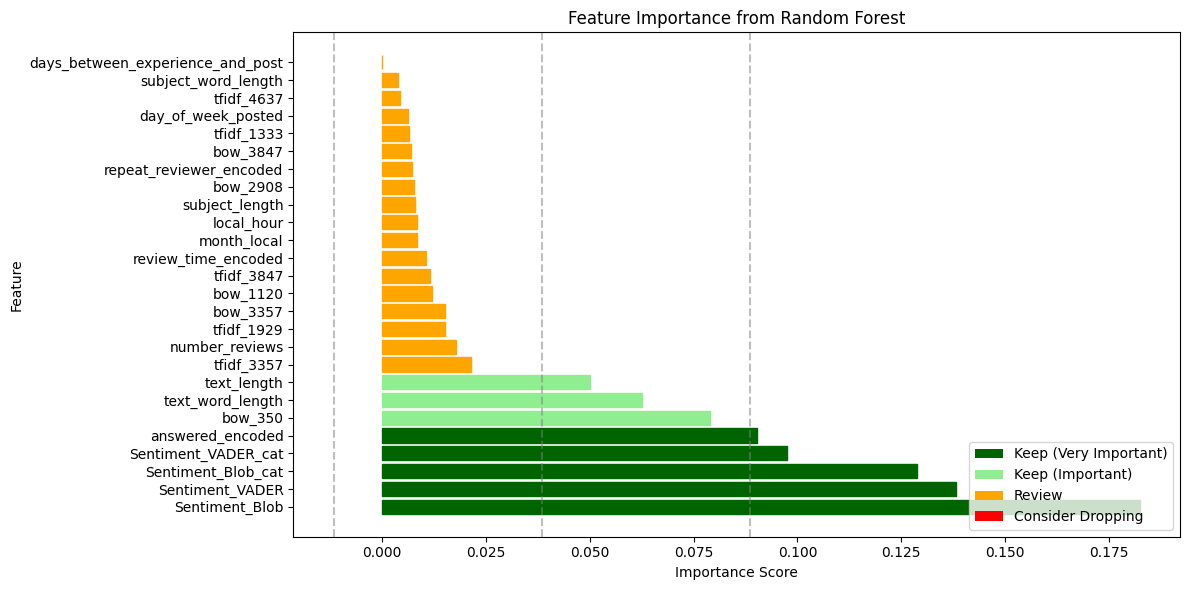

In [525]:
#Random Forest Importance
warnings.filterwarnings('ignore')

def analyze_random_forest_importance():
    features_to_include = []
    features_to_include.extend(true_numeric)
    features_to_include.extend(time_based_numeric)
    features_to_include.extend([f for f in binary_variables if f.endswith('_encoded')])
    features_to_include.extend([f for f in categorical_ordinal if f != 'rating'])
    
    X = train_df[features_to_include].copy()
    
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        X = pd.concat([X, tfidf_df[top_tfidf_cols]], axis=1)
    
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        X = pd.concat([X, bow_df[top_bow_cols]], axis=1)
    
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10, 
        min_samples_split=5, 
        min_samples_leaf=2,  
        n_jobs=-1,
        random_state=42
    )
    
    rf.fit(X_scaled, y)
    
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    mean_importance = importance_df['importance'].mean()
    std_importance = importance_df['importance'].std()
    
    importance_df['status'] = importance_df['importance'].apply(
        lambda x: 'Keep (Very Important)' if x > mean_importance + std_importance
        else 'Keep (Important)' if x > mean_importance
        else 'Consider Dropping' if x < mean_importance - std_importance
        else 'Review'
    )
    
    print("Random Forest Feature Importance Analysis")
    print("=" * 50)
    
    for status in ['Keep (Very Important)', 'Keep (Important)', 'Review', 'Consider Dropping']:
        features = importance_df[importance_df['status'] == status]
        if not features.empty:
            print(f"\n{status}:")
            for _, row in features.iterrows():
                print(f"  - {row['feature']}: {row['importance']:.4f}")
    
    print("\nImportance Thresholds:")
    print(f"Very Important: > {(mean_importance + std_importance):.4f}")
    print(f"Important: > {mean_importance:.4f}")
    print(f"Review: > {(mean_importance - std_importance):.4f}")
    print(f"Consider Dropping: ≤ {(mean_importance - std_importance):.4f}")
    
    
    plt.figure(figsize=(12, 6))
    colors = ['darkgreen', 'lightgreen', 'orange', 'red']
    status_colors = {
        'Keep (Very Important)': colors[0],
        'Keep (Important)': colors[1],
        'Review': colors[2],
        'Consider Dropping': colors[3]
    }
    
    bars = plt.barh(importance_df['feature'], importance_df['importance'])
    
    for bar, status in zip(bars, importance_df['status']):
        bar.set_color(status_colors[status])
    
    plt.axvline(x=mean_importance + std_importance, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=mean_importance, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=mean_importance - std_importance, color='gray', linestyle='--', alpha=0.5)
    
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance from Random Forest')
    

    legend_elements = [Patch(facecolor=color, label=status)
                      for status, color in status_colors.items()]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'importance_df': importance_df,
        'thresholds': {
            'very_important': mean_importance + std_importance,
            'important': mean_importance,
            'review': mean_importance - std_importance
        }
    }

rf_results = analyze_random_forest_importance()

STAGE 13 - LOGISTIC REGRESSION WITH RIB RATIO STUDY

In [526]:
#Logistic Regresison with rib ratio study


warnings.filterwarnings('ignore')

def analyze_logistic_rib_ratio(column_name, data, feature_type='numeric', feature_data=None):
    if feature_data is None:
        if column_name not in data.columns:
            return None
        X = data[column_name].values.reshape(-1, 1)
    else:
        X = feature_data.reshape(-1, 1)
    
    y = (data['rating'] >= 4).astype(int)
    
    try:
        n_bins = 10 if feature_type != 'binary' else 2
        bins = np.percentile(X.ravel(), np.linspace(0, 100, n_bins))
        bin_indices = np.digitize(X.ravel(), bins)
        
        rib_ratios = []
        bin_sizes = []
        for i in range(1, len(bins) + 1):
            mask = bin_indices == i
            if sum(mask) > 0:
                ratio = np.mean(y[mask]) / (1 - np.mean(y[mask]) + 1e-10)
                rib_ratios.append(ratio)
                bin_sizes.append(sum(mask))
        
        rib_stability = np.std(rib_ratios) / (np.mean(rib_ratios) + 1e-10)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train, y_train)
        
        coef = model.coef_[0][0]
        odds_ratio = np.exp(coef)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        correlation, p_value = stats.pointbiserialr(y, X.ravel())
        
        max_rib = max(rib_ratios)
        min_rib = min(rib_ratios)
        rib_range = max_rib - min_rib
        
        result = {
            'feature': column_name,
            'type': feature_type,
            'metrics': {
                'auc': auc_score,
                'rib_range': rib_range,
                'rib_stability': rib_stability,
                'p_value': p_value,
                'odds_ratio': odds_ratio,
                'correlation': correlation
            }
        }
        
        criteria_met = {
            'significant': p_value < 0.05,
            'predictive': auc_score > 0.6,
            'good_range': 1.0 < rib_range < 10.0,
            'stable': rib_stability < 1.0
        }
        
        result['criteria_met'] = criteria_met
        result['keep'] = all(criteria_met.values())
        
        return result
        
    except Exception as e:
        print(f"Error analyzing {column_name}: {str(e)}")
        return None

def display_results(results_df):
    print("\nFeature Analysis Results")
    print("=" * 80)
    
    for feat_type in results_df['type'].unique():
        type_results = results_df[results_df['type'] == feat_type]
        keep = type_results[type_results['keep']]
        drop = type_results[~type_results['keep']]
        
        print(f"\n{feat_type.upper()} FEATURES")
        print("=" * 40)
        
        if not keep.empty:
            print("\nRECOMMENDED TO KEEP:")
            print("-" * 30)
            for _, row in keep.iterrows():
                print(f"\n{row['feature']}:")
                print(f"  AUC: {row['metrics']['auc']:.3f}")
                print(f"  RIB range: {row['metrics']['rib_range']:.3f}")
                print(f"  RIB stability: {row['metrics']['rib_stability']:.3f}")
                print(f"  Odds ratio: {row['metrics']['odds_ratio']:.3f}")
                print(f"  p-value: {row['metrics']['p_value']:.2e}")
                print(f"  Correlation: {row['metrics']['correlation']:.3f}")
        
        if not drop.empty:
            print("\nRECOMMENDED TO DROP:")
            print("-" * 30)
            for _, row in drop.iterrows():
                print(f"\n{row['feature']}:")
                print("  Failed criteria:")
                if not row['criteria_met']['significant']:
                    print("  - Not statistically significant")
                if not row['criteria_met']['predictive']:
                    print("  - Poor predictive power (AUC ≤ 0.6)")
                if not row['criteria_met']['good_range']:
                    print("  - RIB range outside acceptable bounds (1.0-10.0)")
                if not row['criteria_met']['stable']:
                    print("  - Unstable RIB ratios")
                print(f"  Current metrics:")
                print(f"  - AUC: {row['metrics']['auc']:.3f}")
                print(f"  - RIB range: {row['metrics']['rib_range']:.3f}")
                print(f"  - RIB stability: {row['metrics']['rib_stability']:.3f}")
                print(f"  - p-value: {row['metrics']['p_value']:.2e}")
                print(f"  - Correlation: {row['metrics']['correlation']:.3f}")

def run_rib_analysis():
    results = []
    
    feature_groups = {
        'numeric': true_numeric + time_based_numeric,
        'binary': [f for f in binary_variables if f.endswith('_encoded')],
        'ordinal': [f for f in categorical_ordinal if f != 'rating']
    }
    
    for feature_type, features in feature_groups.items():
        for feature in features:
            if feature in train_df.columns:
                result = analyze_logistic_rib_ratio(feature, train_df, feature_type)
                if result is not None:  
                    results.append(result)
    
    if 'X_train_tfidf' in globals() and isinstance(X_train_tfidf, np.ndarray):
        tfidf_data = pd.DataFrame(X_train_tfidf[:, :len(top_tfidf_cols)], columns=top_tfidf_cols)
        for feature in top_tfidf_cols:
            result = analyze_logistic_rib_ratio(
                feature, 
                train_df, 
                'TF-IDF',
                feature_data=tfidf_data[feature].values
            )
            if result is not None:
                results.append(result)
    
    if 'X_train_bow' in globals() and isinstance(X_train_bow, np.ndarray):
        bow_data = pd.DataFrame(X_train_bow[:, :len(top_bow_cols)], columns=top_bow_cols)
        for feature in top_bow_cols:
            result = analyze_logistic_rib_ratio(
                feature, 
                train_df, 
                'BoW',
                feature_data=bow_data[feature].values
            )
            if result is not None:
                results.append(result)
    
    if not results:  
        print("No features were successfully analyzed.")
        return None
    
    results_df = pd.DataFrame(results)
    display_results(results_df)
    return results_df

rib_results = run_rib_analysis()


Feature Analysis Results

NUMERIC FEATURES

RECOMMENDED TO KEEP:
------------------------------

number_reviews:
  AUC: 0.641
  RIB range: 1.813
  RIB stability: 0.531
  Odds ratio: 0.711
  p-value: 0.00e+00
  Correlation: -0.282

text_length:
  AUC: 0.703
  RIB range: 4.124
  RIB stability: 0.701
  Odds ratio: 0.994
  p-value: 0.00e+00
  Correlation: -0.369

text_word_length:
  AUC: 0.714
  RIB range: 4.430
  RIB stability: 0.726
  Odds ratio: 0.955
  p-value: 0.00e+00
  Correlation: -0.389

RECOMMENDED TO DROP:
------------------------------

Sentiment_Blob:
  Failed criteria:
  - RIB range outside acceptable bounds (1.0-10.0)
  - Unstable RIB ratios
  Current metrics:
  - AUC: 0.861
  - RIB range: 32.819
  - RIB stability: 1.296
  - p-value: 0.00e+00
  - Correlation: 0.578

Sentiment_VADER:
  Failed criteria:
  - RIB range outside acceptable bounds (1.0-10.0)
  - Unstable RIB ratios
  Current metrics:
  - AUC: 0.831
  - RIB range: 9999999999.945
  - RIB stability: 3.000
  - p-value

STAGE 14 - ENCODING

In [527]:
#Encoding

def encode_features(train_df, test_df):
    # 1. Ordinal Encoding
    # time_of_day encoding
    time_of_day_order = ['Morning', 'Business Hours', 'Evening', 'Night']
    train_df['time_of_day_encoded'] = pd.Categorical(
        train_df['time_of_day'], 
        categories=time_of_day_order
    ).codes
    test_df['time_of_day_encoded'] = pd.Categorical(
        test_df['time_of_day'], 
        categories=time_of_day_order
    ).codes
    
    # verification encoding
    verification_order = ['Verified', 'Invited', 'Redirected', 'Not Verified']
    train_df['verification_encoded'] = pd.Categorical(
        train_df['verification'], 
        categories=verification_order
    ).codes
    test_df['verification_encoded'] = pd.Categorical(
        test_df['verification'], 
        categories=verification_order
    ).codes
    
    # 2. Label Encoding for location
    # Get all unique locations from both train and test
    all_locations = pd.concat([train_df['location'], test_df['location']]).unique()
    location_map = {loc: idx for idx, loc in enumerate(sorted(all_locations))}
    
    train_df['location_encoded'] = train_df['location'].map(location_map)
    test_df['location_encoded'] = test_df['location'].map(location_map)
    
    # 3. One-Hot Encoding
    # Get all unique values from both train and test for each categorical column
    for column in ['company', 'day_type']:
        # Get all possible values from both datasets
        all_values = pd.concat([train_df[column], test_df[column]]).unique()
        
        # Create dummy columns for train
        dummy_cols = pd.get_dummies(train_df[column], prefix=column, dtype=int)
        train_df = pd.concat([train_df, dummy_cols], axis=1)
        
        # Create dummy columns for test
        dummy_cols_test = pd.get_dummies(test_df[column], prefix=column, dtype=int)
        
        # Ensure both datasets have the same columns
        for val in all_values:
            col_name = f"{column}_{val}"
            if col_name not in dummy_cols.columns:
                train_df[col_name] = 0
            if col_name not in dummy_cols_test.columns:
                test_df[col_name] = 0
    
    return train_df, test_df

train_df, test_df = encode_features(train_df, test_df)

In [528]:
display(train_df.head())
print(train_df.info())

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded,time_of_day_encoded,verification_encoded,location_encoded,company_Asda,company_Flashbay,company_Quicken,company_SteelSeries,day_type_Business Day,day_type_Weekend
0,5,US,Paul D.,1,Verified,one-time,0,Flashbay,fast and efficient web site that allowed a simple interface to to upload my logo and choose my product. The whole process was quick and the product was of great quality.,fast efficient web site allowed simple interface upload logo choose product whole process quick product great quality,117,17,0.307,4.0,0.784,5,fast and efficient web site that…,fast efficient web site,23.0,4.0,"Hello Paul,That is Flashbay for you!Glad that you have found the ordering process easy, and are pleased with the final product.We appreciate your business, and look forward to working with you next time!-Flashbay Management",hello paulthat flashbay youglad found ordering process easy pleased final productwe appreciate business look forward working next timeflashbay management,1,2021-08-11,2021-08-11 17:03:19,2021-08-11,8,10,Business Hours,2,Business Day,0,quick_review,1,1,0,135,0,1,0,0,1,0
1,4,US,Tim Deutschle,1,Verified,one-time,0,Quicken,"I have used Quicken for many years, more than 30 years for sure. I find it difficult sometimes when adding accounts. Also, when entering CD’s and establishing a maturity schedule.",used quicken many years 30 years sure find difficult sometimes adding accounts also entering cds establishing maturity schedule,127,18,0.167,3.0,-0.052,3,I have used Quicken for many years,used quicken many years,23.0,4.0,0,0,0,2024-04-24,2024-05-01 16:23:54,2024-05-01,5,9,Business Hours,2,Business Day,0,late_review,0,1,0,135,0,0,1,0,1,0
2,1,GB,Matthew Hanshaw,2,Not Verified,repeat,1,Asda,A pile of s**t !!!!!!!!!!! Also you don’t even warrant a star had to select it to leave this review.,pile st also dont even warrant star select leave review,55,10,0.000,3.0,-0.052,3,A pile of s**t,pile st,7.0,2.0,0,0,0,2023-08-07,2023-08-08 21:16:55,2023-08-08,8,20,Evening,1,Business Day,0,late_review,0,2,3,52,1,0,0,0,1,0
3,2,US,Michael,1,Invited,one-time,0,Quicken,Not a super useful or intuitive tool. Better free options exist.,super useful intuitive tool better free options exist,53,8,0.383,4.0,0.919,5,Not a super useful or intuitive tool,super useful intuitive tool,27.0,4.0,0,0,0,2023-09-05,2023-09-05 18:27:02,2023-09-05,9,11,Business Hours,1,Business Day,0,quick_review,1,1,1,135,0,0,1,0,1,0
4,2,US,Alan,2,Invited,repeat,1,Quicken,not intuitive....poor guidelines and instructions on usage,intuitivepoor guidelines instructions usage,43,4,0.000,3.0,0.000,3,not intuitive....poor guidelines and…,intuitivepoor guidelines,24.0,2.0,0,0,0,2021-12-08,2021-12-08 02:43:54,2021-12-07,12,19,Evening,1,Business Day,0,quick_review,1,2,1,135,0,0,1,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51382 entries, 0 to 51381
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            51382 non-null  int64         
 1   location                          51382 non-null  object        
 2   username                          51382 non-null  object        
 3   number_reviews                    51382 non-null  int64         
 4   verification                      51382 non-null  object        
 5   repeat_reviewer                   51382 non-null  object        
 6   repeat_reviewer_encoded           51382 non-null  int64         
 7   company                           51382 non-null  object        
 8   text                              51382 non-null  object        
 9   text_processed                    51382 non-null  object        
 10  text_length                       51382 non-nu

STAGE 15 - SCALING/NORMALIZATION/STANDARDIZATION

In [529]:
#Scaling and normalization

def scale_features(train_df, test_df):
   standardize_columns = [
       'text_length', 'subject_length',
       'text_word_length', 'subject_word_length',
       'days_between_experience_and_post',
       'number_reviews'
   ]
   
   normalize_columns = [
       'location_encoded',
       'verification_encoded',
       'time_of_day_encoded'
   ]
   
   std_scaler = StandardScaler()
   minmax_scaler = MinMaxScaler()
   
   if standardize_columns:
       train_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.fit_transform(
           train_df[standardize_columns]
       )
       test_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.transform(
           test_df[standardize_columns]
       )
   
   if normalize_columns:
       train_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.fit_transform(
           train_df[normalize_columns]
       )
       test_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.transform(
           test_df[normalize_columns]
       )
   
   return train_df, test_df, {'standard': std_scaler, 'minmax': minmax_scaler}

train_df, test_df, scalers = scale_features(train_df, test_df)

print("\nTraining set statistics after scaling:")
print("\nStandardized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_scaled')]].describe())
print("\nNormalized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_normalized')]].describe())


Training set statistics after scaling:

Standardized features:
       text_length_scaled  subject_length_scaled  text_word_length_scaled  subject_word_length_scaled  days_between_experience_and_post_scaled  number_reviews_scaled
count           5.138e+04              5.138e+04                5.138e+04                   5.138e+04                                  51382.0              5.138e+04
mean            1.673e-17              8.781e-18                4.010e-17                  -3.927e-17                                      0.0              6.085e-18
std             1.000e+00              1.000e+00                1.000e+00                   1.000e+00                                      0.0              1.000e+00
min            -1.255e+00             -2.373e+00               -1.206e+00                  -1.702e+00                                      0.0             -6.759e-01
25%            -7.726e-01             -6.990e-01               -7.871e-01                  -3.561e-01     

STAGE 15 - ANALYSIS OF ENCODED/NORMALIZED/SCALED FEATURES

In [530]:
def analyze_transformed_features(train_df, test_df):
    exclude_features = ['answered_encoded', 'repeat_reviewer_encoded', 'review_time_encoded']
    transformed_features = [
        col for col in train_df.columns 
        if (col.endswith(('_encoded', '_scaled', '_normalized')) 
            and col not in exclude_features 
            and col != 'rating')
    ]
    
    if not transformed_features:
        print("No transformed features found to analyze!")
        return None
        
    X = train_df[transformed_features]
    y = train_df['rating']
    
    results = pd.DataFrame(index=transformed_features)
    
    # 1. Random Forest Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    results['RF_Importance'] = rf.feature_importances_
    results['RF_Rank'] = results['RF_Importance'].rank(ascending=False)
    
    # 2. LASSO Analysis
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(StandardScaler().fit_transform(X), y)
    results['LASSO_Coef'] = np.abs(lasso.coef_)
    results['LASSO_Rank'] = results['LASSO_Coef'].rank(ascending=False)
    
    # 3. RFE Analysis
    rfe = RFECV(
        estimator=LogisticRegression(max_iter=1000),
        step=1,
        cv=5,
        min_features_to_select=1,
        scoring='accuracy'
    )
    rfe.fit(X, y)
    results['RFE_Selected'] = rfe.support_
    results['RFE_Rank'] = rfe.ranking_
    
    results['Mean_Rank'] = results[['RF_Rank', 'LASSO_Rank', 'RFE_Rank']].mean(axis=1)
    
    results['Feature_Type'] = results.index.map(
        lambda x: 'Encoded' if x.endswith('_encoded') else
                 'Scaled' if x.endswith('_scaled') else
                 'Normalized' if x.endswith('_normalized') else 'Other'
    )
    
    def get_recommendation(row):
        conditions = []
        if row['RF_Importance'] > np.percentile(results['RF_Importance'], 70):
            conditions.append('High RF')
        if row['LASSO_Coef'] > 0:
            conditions.append('LASSO Selected')
        if row['RFE_Selected']:
            conditions.append('RFE Selected')
            
        if len(conditions) >= 2:
            return 'Keep', ', '.join(conditions)
        else:
            reasons = []
            if row['RF_Importance'] <= np.percentile(results['RF_Importance'], 30):
                reasons.append('Low RF')
            if row['LASSO_Coef'] == 0:
                reasons.append('LASSO Eliminated')
            if not row['RFE_Selected']:
                reasons.append('RFE Eliminated')
            return 'Drop', ', '.join(reasons)
    
    recommendations = results.apply(get_recommendation, axis=1)
    results['Decision'] = [rec[0] for rec in recommendations]
    results['Reason'] = [rec[1] for rec in recommendations]
    
    results = results.sort_values('Mean_Rank')
    
    display_cols = [
        'Feature_Type',
        'RF_Importance',
        'LASSO_Coef',
        'RFE_Selected',
        'Mean_Rank',
        'Decision',
        'Reason'
    ]
    
    display_df = results[display_cols].round(4)
    
    print("\nFeature Analysis Summary")
    print("=" * 80)
    display(display_df)
    
    print("\nSummary by Feature Type")
    print("=" * 80)
    type_summary = pd.DataFrame({
        'Total': results.groupby('Feature_Type').size(),
        'Keep': results[results['Decision'] == 'Keep'].groupby('Feature_Type').size(),
        'Drop': results[results['Decision'] == 'Drop'].groupby('Feature_Type').size()
    }).fillna(0).astype(int)
    display(type_summary)
    
    print("\nFinal Recommendations")
    print("=" * 80)
    keep_features = results[results['Decision'] == 'Keep'].index.tolist()
    print(f"\nRecommended features to keep ({len(keep_features)}):")
    for feature in keep_features:
        reason = results.loc[feature, 'Reason']
        print(f"- {feature}: {reason}")
    
    return results, keep_features

results_df, selected_features = analyze_transformed_features(train_df, test_df)


if selected_features:
    train_df_final = train_df[selected_features + ['rating']]
    test_df_final = test_df[selected_features + ['rating']]
    
    print("\nFinal Dataset Shapes:")
    print(f"Training set: {train_df_final.shape}")
    print(f"Test set: {test_df_final.shape}")


Feature Analysis Summary


,Feature_Type,RF_Importance,LASSO_Coef,RFE_Selected,Mean_Rank,Decision,Reason
text_length_scaled,Scaled,0.298,1.235,True,1.333,Keep,"High RF, LASSO Selected, RFE Selected"
text_word_length_scaled,Scaled,0.164,1.608,True,1.667,Keep,"High RF, LASSO Selected, RFE Selected"
verification_encoded,Encoded,0.071,0.643,True,2.667,Keep,"High RF, LASSO Selected, RFE Selected"
subject_length_scaled,Scaled,0.202,0.048,True,3.000,Keep,"High RF, LASSO Selected, RFE Selected"
subject_word_length_scaled,Scaled,0.050,0.084,True,4.000,Keep,"LASSO Selected, RFE Selected"
location_encoded,Encoded,0.036,0.094,True,4.667,Keep,"LASSO Selected, RFE Selected"
number_reviews_scaled,Scaled,0.048,0.037,True,5.000,Keep,"LASSO Selected, RFE Selected"
verification_encoded_normalized,Normalized,0.056,0.000,True,5.667,Drop,LASSO Eliminated
time_of_day_encoded,Encoded,0.015,0.000,True,6.667,Keep,"LASSO Selected, RFE Selected"
location_encoded_normalized,Normalized,0.044,0.000,True,6.667,Drop,LASSO Eliminated



Summary by Feature Type


,Total,Keep,Drop
Feature_Type,,,
Encoded,3,3,0
Normalized,3,1,2
Scaled,6,5,1



Final Recommendations

Recommended features to keep (9):
- text_length_scaled: High RF, LASSO Selected, RFE Selected
- text_word_length_scaled: High RF, LASSO Selected, RFE Selected
- verification_encoded: High RF, LASSO Selected, RFE Selected
- subject_length_scaled: High RF, LASSO Selected, RFE Selected
- subject_word_length_scaled: LASSO Selected, RFE Selected
- location_encoded: LASSO Selected, RFE Selected
- number_reviews_scaled: LASSO Selected, RFE Selected
- time_of_day_encoded: LASSO Selected, RFE Selected
- time_of_day_encoded_normalized: LASSO Selected, RFE Selected

Final Dataset Shapes:
Training set: (51382, 10)
Test set: (12846, 10)


In [531]:
#Final Multicollinearity Check
def check_final_multicollinearity(train_df):
    features = [
        'Sentiment_Blob', 'number_reviews', 'Sentiment_VADER', 'text_word_length',
        'text_word', 'repeat_reviewer_encoded', 'text_length_scaled',
        'text_word_length_scaled', 'verification_encoded', 'subject_length_scaled',
        'subject_word_length_scaled', 'location_encoded', 'number_reviews_scaled',
        'time_of_day_encoded', 'time_of_day_encoded_normalized'
    ]
    
    features = [f for f in features if f in train_df.columns]
    
    # Calculate correlation matrix
    corr_matrix = train_df[features].corr()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            correlation = abs(corr_matrix.iloc[i, j])
            if correlation > 0.7:  
                feature1 = features[i]
                feature2 = features[j]
                
                # Determine which feature to keep
                keep_feature = None
                reason = None
                
                # Rule 1: If one is scaled version of other, prefer scaled
                if feature1.replace('_scaled', '') == feature2 or feature2.replace('_scaled', '') == feature1:
                    keep_feature = feature1 if '_scaled' in feature1 else feature2
                    reason = "Scaled version preferred over original"
                
                # Rule 2: If one is normalized version, prefer normalized
                elif feature1.replace('_normalized', '') == feature2 or feature2.replace('_normalized', '') == feature1:
                    keep_feature = feature1 if '_normalized' in feature1 else feature2
                    reason = "Normalized version preferred over encoded"
                
                # Rule 3: For text length metrics, prefer word length over character length
                elif ('text_length' in feature1 and 'text_word_length' in feature2) or \
                     ('text_length' in feature2 and 'text_word_length' in feature1):
                    keep_feature = feature1 if 'word' in feature1 else feature2
                    reason = "Word length preferred over character length"
                
                # Rule 4: For sentiment scores, prefer VADER
                elif ('Sentiment_Blob' in feature1 and 'Sentiment_VADER' in feature2) or \
                     ('Sentiment_Blob' in feature2 and 'Sentiment_VADER' in feature1):
                    keep_feature = feature1 if 'VADER' in feature1 else feature2
                    reason = "VADER sentiment preferred over TextBlob"
                
                # Default: Keep feature with higher correlation with target
                else:
                    corr1 = abs(train_df[feature1].corr(train_df['rating']))
                    corr2 = abs(train_df[feature2].corr(train_df['rating']))
                    keep_feature = feature1 if corr1 > corr2 else feature2
                    reason = "Stronger correlation with target"
                
                drop_feature = feature2 if keep_feature == feature1 else feature1
                
                high_corr_pairs.append({
                    'Feature1': feature1,
                    'Feature2': feature2,
                    'Correlation': correlation,
                    'Keep': keep_feature,
                    'Drop': drop_feature,
                    'Reason': reason
                })
    
    # Create results DataFrame
    results_df = pd.DataFrame(high_corr_pairs)
    
    if len(results_df) == 0:
        print("No high multicollinearity found among the features!")
        return None
    
    # Sort by correlation strength
    results_df = results_df.sort_values('Correlation', ascending=False)
    
    print("\nMulticollinearity Analysis")
    print("=" * 80)
    display(results_df)
    
    # Create final feature recommendations
    print("\nFinal Recommendations:")
    print("=" * 80)
    features_to_keep = set(features) - set(results_df['Drop'].unique())
    print("\nFeatures to Keep:")
    for feature in sorted(features_to_keep):
        print(f"- {feature}")
    
    print("\nFeatures to Drop:")
    for feature in sorted(set(results_df['Drop'].unique())):
        pairs = results_df[results_df['Drop'] == feature]
        print(f"- {feature} (correlates with: {', '.join(pairs['Keep'])})")
    
    # Preview final features
    print("\nPreview of Final Features (First 5 rows):")
    print("=" * 80)
    features_to_keep_list = sorted(list(features_to_keep))
    display(train_df[features_to_keep_list + ['rating']].head())
    
    # Display basic statistics for final features
    print("\nBasic Statistics for Final Features:")
    print("=" * 80)
    stats_df = train_df[features_to_keep_list].describe()
    display(stats_df)
    
    # Check for any remaining nulls or issues
    print("\nNull Value Check for Final Features:")
    print("=" * 80)
    null_check = train_df[features_to_keep_list].isnull().sum()
    if null_check.sum() > 0:
        print("Warning: Null values found in final features!")
        display(null_check[null_check > 0])
    else:
        print("No null values found in final features.")
    
    return results_df, features_to_keep_list

multicollinearity_results, final_features = check_final_multicollinearity(train_df)


Multicollinearity Analysis


,Feature1,Feature2,Correlation,Keep,Drop,Reason
3,text_word_length,text_word_length_scaled,1.000,text_word_length_scaled,text_word_length,Scaled version preferred over original
7,time_of_day_encoded,time_of_day_encoded_normalized,1.000,time_of_day_encoded_normalized,time_of_day_encoded,Normalized version preferred over encoded
1,number_reviews,number_reviews_scaled,1.000,number_reviews_scaled,number_reviews,Scaled version preferred over original
2,text_word_length,text_length_scaled,0.994,text_word_length,text_length_scaled,Word length preferred over character length
5,text_length_scaled,text_word_length_scaled,0.994,text_word_length_scaled,text_length_scaled,Word length preferred over character length
6,subject_length_scaled,subject_word_length_scaled,0.870,subject_word_length_scaled,subject_length_scaled,Stronger correlation with target
4,repeat_reviewer_encoded,number_reviews_scaled,0.766,number_reviews_scaled,repeat_reviewer_encoded,Stronger correlation with target
0,number_reviews,repeat_reviewer_encoded,0.766,number_reviews,repeat_reviewer_encoded,Stronger correlation with target



Final Recommendations:

Features to Keep:
- Sentiment_Blob
- Sentiment_VADER
- location_encoded
- number_reviews_scaled
- subject_word_length_scaled
- text_word_length_scaled
- time_of_day_encoded_normalized
- verification_encoded

Features to Drop:
- number_reviews (correlates with: number_reviews_scaled)
- repeat_reviewer_encoded (correlates with: number_reviews_scaled, number_reviews)
- subject_length_scaled (correlates with: subject_word_length_scaled)
- text_length_scaled (correlates with: text_word_length, text_word_length_scaled)
- text_word_length (correlates with: text_word_length_scaled)
- time_of_day_encoded (correlates with: time_of_day_encoded_normalized)

Preview of Final Features (First 5 rows):


,Sentiment_Blob,Sentiment_VADER,location_encoded,number_reviews_scaled,subject_word_length_scaled,text_word_length_scaled,time_of_day_encoded_normalized,verification_encoded,rating
0,0.307,0.784,135,-0.676,0.541,-0.368,0.333,0,5
1,0.167,-0.052,135,-0.676,0.541,-0.315,0.333,0,4
2,0.000,-0.052,52,-0.093,-1.253,-0.735,0.667,3,1
3,0.383,0.919,135,-0.676,0.541,-0.839,0.333,1,2
4,0.000,0.000,135,-0.093,-1.253,-1.049,0.667,1,2



Basic Statistics for Final Features:


,Sentiment_Blob,Sentiment_VADER,location_encoded,number_reviews_scaled,subject_word_length_scaled,text_word_length_scaled,time_of_day_encoded_normalized,verification_encoded
count,51382.000,51382.000,51382.000,5.138e+04,5.138e+04,5.138e+04,51382.000,51382.000
mean,0.189,0.330,109.868,6.085e-18,-3.927e-17,4.010e-17,0.364,0.755
std,0.298,0.553,39.343,1.000e+00,1.000e+00,1.000e+00,0.256,1.191
min,-0.933,-0.997,0.000,-6.759e-01,-1.702e+00,-1.206e+00,0.000,0.000
25%,0.000,0.000,52.000,-6.759e-01,-3.561e-01,-7.871e-01,0.333,0.000
50%,0.178,0.477,135.000,-6.759e-01,-3.561e-01,-3.154e-01,0.333,0.000
75%,0.400,0.802,135.000,4.897e-01,5.411e-01,4.708e-01,0.333,1.000
max,1.000,0.998,143.000,2.238e+00,1.887e+00,2.358e+00,1.000,3.000



Null Value Check for Final Features:
No null values found in final features.


In [536]:
#Standardize final features
def standardize_selected_features(train_df, test_df, final_features):
    global X_train, X_test, y_train, y_test
    
    scaler = StandardScaler()
    
    X_train = train_df[final_features].copy()
    X_test = test_df[final_features].copy()
    y_train = train_df['rating']
    y_test = test_df['rating']
    
    # Fit and transform training data
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    # Transform test data using the same scaler
    X_test = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    # Verify standardization results
    print("Verification of Standardization:")
    print("=" * 50)
    print("\nTraining Data Statistics:")
    print("-" * 30)
    display(X_train.describe())
    
    train_means = X_train.mean()
    train_stds = X_train.std()
    
    print("\nStandardization Check:")
    print("-" * 30)
    verification_df = pd.DataFrame({
        'mean': train_means,
        'std': train_stds
    })
    display(verification_df)
    
    print("\nPreview of standardized training data:")
    print("-" * 30)
    display(X_train.head())
    
    print("\nFinal shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")

standardize_selected_features(train_df, test_df, final_features)

Verification of Standardization:

Training Data Statistics:
------------------------------


,Sentiment_Blob,Sentiment_VADER,location_encoded,number_reviews_scaled,subject_word_length_scaled,text_word_length_scaled,time_of_day_encoded_normalized,verification_encoded
count,5.138e+04,5.138e+04,5.138e+04,5.138e+04,5.138e+04,5.138e+04,5.138e+04,5.138e+04
mean,-1.216e-16,2.752e-17,-9.929e-17,6.085e-18,-2.178e-17,2.600e-17,-1.282e-16,-7.281e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-3.764e+00,-2.398e+00,-2.793e+00,-6.759e-01,-1.702e+00,-1.206e+00,-1.424e+00,-6.340e-01
25%,-6.342e-01,-5.957e-01,-1.471e+00,-6.759e-01,-3.561e-01,-7.871e-01,-1.201e-01,-6.340e-01
50%,-3.791e-02,2.657e-01,6.388e-01,-6.759e-01,-3.561e-01,-3.154e-01,-1.201e-01,-6.340e-01
75%,7.074e-01,8.535e-01,6.388e-01,4.897e-01,5.411e-01,4.708e-01,-1.201e-01,2.058e-01
max,2.720e+00,1.208e+00,8.421e-01,2.238e+00,1.887e+00,2.358e+00,2.488e+00,1.885e+00



Standardization Check:
------------------------------


,mean,std
Sentiment_Blob,-1.216e-16,1.0
Sentiment_VADER,2.752e-17,1.0
location_encoded,-9.929e-17,1.0
number_reviews_scaled,6.085e-18,1.0
subject_word_length_scaled,-2.178e-17,1.0
text_word_length_scaled,2.600e-17,1.0
time_of_day_encoded_normalized,-1.282e-16,1.0
verification_encoded,-7.281e-17,1.0



Preview of standardized training data:
------------------------------


,Sentiment_Blob,Sentiment_VADER,location_encoded,number_reviews_scaled,subject_word_length_scaled,text_word_length_scaled,time_of_day_encoded_normalized,verification_encoded
0,0.394,0.822,0.639,-0.676,0.541,-0.368,-0.120,-0.634
1,-0.075,-0.689,0.639,-0.676,0.541,-0.315,-0.120,-0.634
2,-0.634,-0.689,-1.471,-0.093,-1.253,-0.735,1.184,1.885
3,0.652,1.064,0.639,-0.676,0.541,-0.839,-0.120,0.206
4,-0.634,-0.596,0.639,-0.093,-1.253,-1.049,1.184,0.206



Final shapes:
X_train: (51382, 8)
X_test: (12846, 8)
y_train: (51382,)
y_test: (12846,)


STAGE 17 - TF-IDF/BOW EVALUATION

In [538]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

def evaluate_text_features():
    """
    Evaluate whether to include TF-IDF and/or BoW features
    Uses global X_train, y_train variables
    """
    # Baseline performance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    baseline_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    
    results = {
        'baseline': baseline_scores.mean()
    }
    
    # Test with TF-IDF
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        X_tfidf = pd.concat([X_train, tfidf_df[top_tfidf_cols]], axis=1)
        tfidf_scores = cross_val_score(rf, X_tfidf, y_train, cv=5, scoring='accuracy')
        results['tfidf'] = tfidf_scores.mean()
    
    # Test with BoW
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        X_bow = pd.concat([X_train, bow_df[top_bow_cols]], axis=1)
        bow_scores = cross_val_score(rf, X_bow, y_train, cv=5, scoring='accuracy')
        results['bow'] = bow_scores.mean()
    
    # Print results
    print("Text Feature Evaluation")
    print("=" * 30)
    print(f"Baseline Score: {results['baseline']:.3f}")
    
    if 'tfidf' in results:
        print(f"With TF-IDF: {results['tfidf']:.3f}")
        print(f"TF-IDF Improvement: {results['tfidf'] - results['baseline']:.3f}")
    
    if 'bow' in results:
        print(f"With BoW: {results['bow']:.3f}")
        print(f"BoW Improvement: {results['bow'] - results['baseline']:.3f}")
    
    # Make recommendations
    print("\nRecommendations:")
    if 'tfidf' in results and results['tfidf'] > results['baseline'] + 0.01:
        print("- Include TF-IDF features")
        if 'tfidf_df' in globals():
            print(f"  Top TF-IDF features: {', '.join(top_tfidf_cols[:5])}...")
    
    if 'bow' in results and results['bow'] > results['baseline'] + 0.01:
        print("- Include BoW features")
        if 'bow_df' in globals():
            print(f"  Top BoW features: {', '.join(top_bow_cols[:5])}...")
    
    if (('tfidf' not in results or results['tfidf'] <= results['baseline'] + 0.01) and
        ('bow' not in results or results['bow'] <= results['baseline'] + 0.01)):
        print("- Exclude text-based features (insufficient improvement)")
    
    return results

# Evaluate text features
text_results = evaluate_text_features()

# If we want to update X_train and X_test with text features based on results
if 'tfidf' in text_results and text_results['tfidf'] > text_results['baseline'] + 0.01:
    print("\nUpdating training and test sets with TF-IDF features...")
    X_train = pd.concat([X_train, tfidf_df[top_tfidf_cols]], axis=1)
    X_test = pd.concat([X_test, tfidf_df[top_tfidf_cols]], axis=1)

if 'bow' in text_results and text_results['bow'] > text_results['baseline'] + 0.01:
    print("\nUpdating training and test sets with BoW features...")
    X_train = pd.concat([X_train, bow_df[top_bow_cols]], axis=1)
    X_test = pd.concat([X_test, bow_df[top_bow_cols]], axis=1)

if X_train.shape[1] > len(final_features):
    print(f"\nFinal feature count increased from {len(final_features)} to {X_train.shape[1]}")

#Based on the results TF-IDF and BoW should be excluded due to insufficient improvement

Text Feature Evaluation
Baseline Score: 0.660
With TF-IDF: 0.667
TF-IDF Improvement: 0.007
With BoW: 0.668
BoW Improvement: 0.008

Recommendations:
- Exclude text-based features (insufficient improvement)


In [539]:
import os

def save_final_datasets():
    os.makedirs('data', exist_ok=True)
    
    # Our final selected features from the analysis
    final_features = [
        'Sentiment_Blob',
        'Sentiment_VADER',
        'location_encoded',
        'number_reviews_scaled',
        'subject_word_length_scaled',
        'text_word_length_scaled',
        'time_of_day_encoded_normalized',
        'verification_encoded'
    ]
    
    # Create final dataframes with features and target
    train_final = pd.concat([
        pd.DataFrame(X_train, columns=final_features),
        pd.DataFrame(y_train, columns=['rating'])
    ], axis=1)
    
    test_final = pd.concat([
        pd.DataFrame(X_test, columns=final_features),
        pd.DataFrame(y_test, columns=['rating'])
    ], axis=1)
    
    # Save datasets
    train_final.to_csv('data/train_final.csv', index=False)
    test_final.to_csv('data/test_final.csv', index=False)
    
    # Save feature list
    with open('data/final_features.txt', 'w') as f:
        f.write('\n'.join(final_features))
    
    print("Datasets saved successfully!")
    print(f"Training set shape: {train_final.shape}")
    print(f"Test set shape: {test_final.shape}")
    print(f"\nFinal features saved to: final_features.txt")
    print("\nFinal features:")
    for feature in final_features:
        print(f"- {feature}")

# Save the datasets
save_final_datasets()

Datasets saved successfully!
Training set shape: (51382, 9)
Test set shape: (12846, 9)

Final features saved to: final_features.txt

Final features:
- Sentiment_Blob
- Sentiment_VADER
- location_encoded
- number_reviews_scaled
- subject_word_length_scaled
- text_word_length_scaled
- time_of_day_encoded_normalized
- verification_encoded
